<p style="font-size: 28px; text-align: center; color: blue"><b>Review of Cardiac Patterns Using Dynamic Time Warping</b></p>
<p style="font-size: 24px; text-align: center; color: blue">Shiker Nair and Brendon Gory, December 14, 2022</p>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
	<ul>
        <li><a href="#Abstract">1 Abstract</a></li>
        <li><a href="#Abstract">2 Introduction</a></li>
		<li><a href="#Analysis">3 Analysis</a></li>
        <ul>
            <li><a href="#Load-libraries">3.1 Load libraries</a></li>
            <li><a href="#Exploratory-data-analysis">3.2 Exploratory data analysis</a></li>
            <ul>
                <li><a href="#Load-data">3.2.1 Load data</a></li>
                <li><a href="#Data-statistics">3.2.2 Data statistics</a></li>
                <li><a href="#Reduce-readings-per-observation">3.2.3 Reduce readings per observation</a></li>
                <li><a href="#Get-patient-list">3.2.4 Get patient list</a></li>
                <li><a href="#Exploratory-data-analysis-summary">3.2.4 Summary</a></li>
            </ul>
            <li><a href="#Dynamic-time-warping-(DTW)">3.2 Dynamic time warping (DTW)</a></li>
            <ul>
                <li><a href="#Plot-DTW-of-ECG-to-APB">3.2.1 Plot DTW of ECG to APB</a></li>
                <li><a href="#Find-outliers">3.2.2 Find outliers</a></li>
                <li><a href="#Linear-Regression">3.2.3 Regression</a></li>
                <li><a href="#Find-outliers">3.2.4 Find outliers</a></li>
            </ul>
            <li><a href="#Linear-regression">3.3 Linear regression</a></li>
            <ul>
                <li><a href="#TS-Fresh-implementation">3.3.1 TS Fresh implementation</a></li>
                <li><a href="#Load-features-from-TS-Fresh">3.3.2 Load features from TS Fresh</a></li>
            </ul>
            <li><a href="#Train-and-test-datasets">3.4 Train and test datasets</a></li>
            <li><a href="#Random-forest">3.5 Random forest</a></li>
            <li><a href="#Xgboost">3.6 Xgboost</a></li>
            <ul>
                <li><a href="#Find-best-n_estimators">3.6.1 Find best n_estimators</a></li>
                <li><a href="#Find-best-max-depth">3.6.2 Find best max depth</a></li>
                <li><a href="#Find-best-colsample_bylevel">3.6.3 Find best colsample_bylevel</a></li>
                <li><a href="#Find-best-colsample_bytree">3.6.4 Find best colsample_bytree</a></li>
                <li><a href="#Find-best-learning-rate">3.6.5 Find best learning rate</a></li>
                <li><a href="#Find-best-reg-lambda">3.6.6 Find best reg lambda</a></li>
            </ul>
            <li><a href="#Forecasting">3.7 Forecasting</a></li>
            <ul>
                <li><a href="#ARIMA">3.7.1 ARIMA</a></li>
                <ul>
                    <li><a href="#ARIMA-on-log-data">3.7.1.1 ARIMA on log data</a></li>
                    <li><a href="#ARIMA-on-reduced-data">3.7.1.2 ARIMA on reduced data</a></li>
                    <li><a href="#ACF-and-PACF-plots">3.7.1.3 ACF and PACF plots</a></li>
                    <li><a href="#Best-ARIMA-with-seasonality">3.7.1.4 Best ARIMA with seasonality</a></li>
                    <li><a href="#ARIMA-prediction">3.7.1.5 ARIMA prediction</a></li>
                </ul>		
            </ul>
        </ul>
        <li><a href="#Conclusion">4 Conclusion</a></li>
	</ul>
</div>

# Abstract

<b>Correlation between ECG and Arterial Blood Pressure Vital Signs</b>

<p>Patients in the intensive care unit have both electrocardiogram (ECG) and invasive arterial blood pressure (ABP) vital monitors for clinicians to quickly assess. ECG aims to measure electrical signals of the hearts as it cycles through systolic and diastolic phases. Invasive arterial blood pressure aims to measure blood pressure and flow from a peripheral artery to understand blood dispersion and cardiac output.</p>
<p>The purpose of this project/paper is to analyze the relationship between ECG and ABP and to see if they can jointly help to forecast either waveform. We hope to show a monotonic correlation between a change in ECG and ABP using dynamic time warping and EDA as a proof of concept that they are related waveforms (a change in ECG results in a change in ABP). To take this idea a step further, we would like to assess whether we can use the ECG waveform to make real-time predictions of ABP. More specifically if we can predict the mean ABP for a given window time using only the ECG waveform for that corresponding window. Finally, we would like to assess how much additional information ABP and ECG provide to their respective counterparts in a forecasting task (can ECG be better forecasted using both ECG and ABP as input time series / can ABP be better forecasted using both ECG and ABP as input time series). We would like to test both deep learning algorithms such as LSTM and statistical based models such as ARIMA and Holt-Winters for this challenge.</p>
<p>To accomplish this task, we would like to use data from the <a href="https://physionet.org/content/mimic3wdb/1.0/">MIMIC III waveform database</a>. This site stores patient recorded waveform data for ECG and ABP, measured at a frequency of 125 Hz. We would like to take a subset of patients and find instances of overlapping recording of ABP and ECG waveforms to use as our preliminary data for this project.</p> 

# Introduction

Patients in the intensive care unit generally have arterial blood pressure (ABP) and electrocardiogram (ECG) continuously measured. ABP provides information about the blood pressure, vein elastance/resistance, and contractile strength. ECG measures the vitality and functionality of the heart, often used to diagnose heart abnormalities (i.e. heart attack). The goal/problem we were interested in solving in our final project was quantifying the relationship between ECG and ABP. Theoretically both are clinically related and can be described using control systems and state space models (changes to ABP effect ECG and vice versa).
Goals:
As such, the goal of this project was to:
1. Quantify the correlation between ABP and ECG
2. Predict the mean ABP value for a window of time only using time and frequency domain
features from ECG
3. Forecast ABP/ECG

# Analysis

## Load libraries

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import spearmanr
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

from numba import jit, cuda

# Keras
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

# Prediction Models
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GroupShuffleSplit
import xgboost as xgb

# DTW
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# RNN
import time
import os

import warnings
warnings.filterwarnings('ignore')

## Exploratory data analysis

### Load data

In [2]:
ecg_data = np.load('D:/cardiac_data/ecg_waveform.npy')
abp_data = np.load('D:/cardiac_data/abp_waveform.npy')
ecg_df = pd.DataFrame(ecg_data)
abp_df = pd.DataFrame(abp_data)
display(ecg_df.head())
display(abp_df.head())

0         1         2         3         4         5         6      \
0  0.704923  0.704923  0.704923  0.700000  0.700000  0.700000  0.704923   
1  0.720000  0.720000  0.730154  0.740000  0.744923  0.740000  0.755077   
2  0.744923  0.740000  0.740000  0.740000  0.740000  0.740000  0.724923   
3  0.755077  0.764923  0.764923  0.770154  0.775077  0.770154  0.775077   
4  0.570154  0.640000  0.675077  0.695077  0.695077  0.695077  0.695077   

      7         8         9      ...     37490     37491     37492     37493  \
0  0.700000  0.695077  0.700000  ...  0.590154  0.600000  0.620000  0.630154   
1  0.755077  0.750154  0.764923  ...  0.730154  0.730154  0.735077  0.730154   
2  0.724923  0.744923  0.750154  ...  0.670154  0.680000  0.695077  0.700000   
3  0.775077  0.775077  0.780000  ...  0.750154  0.775077  0.924923  1.064923   
4  0.695077  0.695077  0.695077  ...  0.740000  0.744923  0.735077  0.764923   

      37494     37495     37496     37497     37498     37499  
0  0.644923  0.660000  0.670154  0.680000  0.695077  0.704923  
1  0.720000  0.710154  0.690154  0.664923  0.644923  0.624923  
2  0.710154  0.720000  0.724923  0.740000  0.740000  0.750154  
3  0.864923  0.410154  0.220000  0.260000  0.344923  0.450154  
4  0.744923  0.750154  0.720000  0.735077  0.730154  0.750154  

[5 rows x 37500 columns]

0           1           2           3          4          5      \
0   58.378302   57.909400   57.479573   57.127897  56.815296  56.502694   
1  108.824345  106.636136  104.135325  101.243763  98.039599  94.679134   
2   75.297850   74.672648   74.008370   73.305017  72.679814  71.976461   
3  112.927238  109.918450  106.636136  103.197521  99.876132  96.867344   
4   68.108019   67.873568   67.678193   67.482817  67.287441  67.131140   

       6          7          8          9      ...       37490       37491  \
0  56.229168  56.033792  56.111943  56.658995  ...  114.920072  115.936026   
1  91.162369  87.880055  84.871267  82.370456  ...   58.808129   58.925355   
2  71.312183  70.686981  70.061778  69.475650  ...  130.940891  129.612335   
3  94.366533  92.490925  91.123294  90.224565  ...   72.054611   71.546634   
4  66.935764  66.623163  66.310562  65.919810  ...   94.249307   92.881676   

        37492       37493       37494       37495       37496       37497  \
0  116.483078  116.678454  116.483078  116.014176  115.115448  113.943193   
1   59.628708   61.348015   64.630329   69.436575   75.415076   81.979704   
2  128.166554  126.681698  125.040540  123.477534  121.797301  119.921693   
3   71.116807   70.686981   70.257154   69.866402   69.436575   69.006748   
4   91.943872   91.318670   90.927918   90.693467   90.302715   89.872888   

        37498       37499  
0  112.497411  110.817179  
1   88.622483   94.913585  
2  117.928860  115.545274  
3   68.615997   68.381546  
4   89.364911   88.661558  

[5 rows x 37500 columns]

### Data statistics

In [3]:
ecg_df = pd.DataFrame(ecg_data)
print(f'ECG Data Shape {ecg_df.shape}')
print(f'NaN values found in ECG data: {ecg_df.isnull().values.any()}')
print(f'ECG Statistics\n{ecg_df.describe()}')

abp_df = pd.DataFrame(abp_data)
print(f'ABP Data Shape {abp_df.shape}')
print(f'NaN values found in ABP data: {abp_df.isnull().values.any()}')
print(f'ABP Statistics\n{abp_df.describe()}')

ECG Data Shape (16414, 37500)
NaN values found in ECG data: False
ECG Statistics
              0             1             2             3             4      \
count  16414.000000  16414.000000  16414.000000  16414.000000  16414.000000   
mean       0.376493      0.375018      0.373193      0.372332      0.371679   
std        0.299407      0.297749      0.295721      0.293398      0.293129   
min       -0.644531     -0.575195     -0.549805     -0.535156     -0.500489   
25%        0.229980      0.229849      0.229717      0.229717      0.229717   
50%        0.363565      0.360039      0.364924      0.365234      0.365103   
75%        0.490225      0.489985      0.485100      0.485100      0.489985   
max        2.324219      1.929688      2.004883      1.934570      1.995117   

              5             6             7             8             9      \
count  16414.000000  16414.000000  16414.000000  16414.000000  16414.000000   
mean       0.373160      0.373613      0.374296  

In [4]:
# ABP observations that are all zeros
zeros = []
for idx, aRow in abp_df.iterrows():
    if aRow.sum() == 0:
        zeros.append(idx)
print(zeros)

[1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 169

In [5]:
abp_df[1524:1722]

0      1      2      3      4      5      6      7      8      9      \
1524    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1525    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1526    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1527    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1528    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1717    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1718    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1719    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1720    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1721    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      ...  37490  37491  37492  37493  37494  37495  37496  37497  37498  \
1524  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1525  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1526  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1527  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1528  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1717  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1718  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1719  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1720  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1721  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

      37499  
1524    0.0  
1525    0.0  
1526    0.0  
1527    0.0  
1528    0.0  
...     ...  
1717    0.0  
1718    0.0  
1719    0.0  
1720    0.0  
1721    0.0  

[198 rows x 37500 columns]

There are observations with ABP = 0. Perhaps these rows should be ignored or not picked during analysis.

### Reduce readings per observation

Reduced 16414 observations
Original data frame (16414, 37500); Reduced data frame (16414, 125)


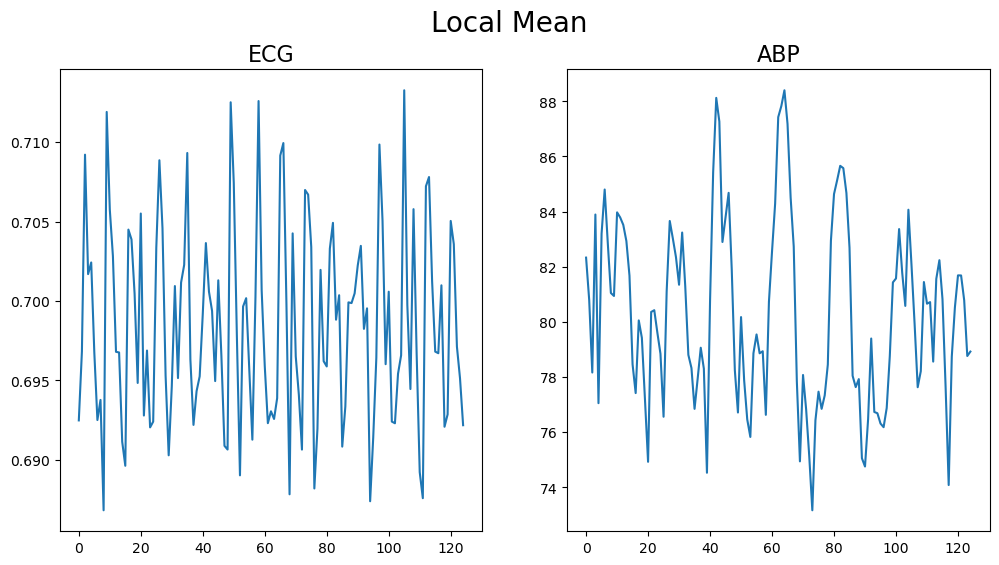

In [6]:
def get_local_val(values, func, step, ax=None, show_plot=False):
    total_len = len(values)
    idx = 0
    local_groups = []
    while (idx + step) <= total_len:
        if func == 'MAX':
            val = max(values[idx:idx + step])
        elif func == 'MIN':
            val = min(values[idx:idx + step])
        elif func == 'MEAN':
            val = np.mean(values[idx:idx + step])
        else:
            raise ValueError(f'{func} not defined. Can only be [MAX, MIN, MEAN].')
        
        local_groups.append(val)
        idx += step
    
    if show_plot:
        return plt.plot(local_groups, ax=ax)
    else:
        return local_groups


"""
Reduce each observation for each data set
Data sets are same size. Shape arbitrarily assigned to any data frame.
"""    
total_obs = ecg_df.shape[0]
total_features = ecg_df.shape[1]
step = int(total_features / 125) # Maxima every 1 second
cols = int(total_features / step)

ecg_temp, abp_temp = [], []
for i in range(0, total_obs):
    ecg_temp.append(get_local_val(ecg_df.loc[i], 'MEAN', step))
    abp_temp.append(get_local_val(abp_df.loc[i], 'MEAN', step))

ecg_subset = pd.DataFrame(columns=[np.arange(0, cols)], data=ecg_temp)
abp_subset = pd.DataFrame(columns=[np.arange(0, cols)], data=abp_temp)   
print(f'Reduced {total_obs} observations')
print(f'Original data frame {ecg_df.shape}; Reduced data frame {ecg_subset.shape}')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0] = sns.lineplot(x=range(0, len(ecg_temp[0])), y=ecg_temp[0], ax=ax[0])
ax[0].set_title('ECG', fontsize=16)
ax[1] = sns.lineplot(x=range(0, len(abp_temp[0])), y=abp_temp[0], ax=ax[1])
ax[1].set_title('ABP', fontsize=16)
fig.suptitle('Local Mean', fontsize=20)
plt.show()

### Get patient list
For data splits and DTW, we want to be sure observations between patients aren't evaluated

In [7]:
pat_data = np.load('D:/cardiac_data/pat_list.npy')
display(pat_data)
len(np.unique(pat_data))
pd.DataFrame(pat_data).value_counts()

array([70420, 70420, 70420, ..., 72377, 72377, 72377], dtype=int64)

44789    2439
97660    1934
76896    1670
85725    1188
87913     884
43116     772
72377     711
59991     689
45703     660
44781     647
48038     571
68564     538
95235     519
81535     474
51858     394
70420     301
74032     266
95088     246
80847     213
48149     185
71059     182
43571     181
42311     176
89909     143
56634     120
54987      99
74899      78
28075      60
95512      39
97158      20
50302      11
89002       3
90990       1
dtype: int64

### Exploratory data analysis summary
The data we used came from MIMIC III Waveform Database Version 1.4. This database contains waveform records for approximately 60,000 ICU patients from the Beth Israel Deaconess Hospital. Each patient with waveform recordings did not necessarily always have ABP and ECG simultaneously recorded. Furthermore, there were different types of ECG waveform recordings (coming from different leads i.e. ECG Lead I vs Lead II). As such, we identified patients with co-occurring ECG Lead II (most prevalent ECG Lead recording) and ABP waveforms for at least 5 minutes. We extracted waveform data from 33 patients all having at least 5 minutes of co-occurring ABP and ECG waveforms. Both these waveforms are measured at 125 Hz (37,500 data points). In total we had 16,414 5 minute windows of data whose dimensions were therefore: (16,414, 37,500) for both ECG and ABP.

During EDA, we felt comfortable with the amount of data to run modeling. There are 33 different patients who have approximately 500 observations for both ABP and ECG measurements. Each observation contains 37,500 features (125 measurements per second for five minutes). The data did not contain any NaN values, but some observations in the ABP read all zeros. This was first detected as outliers in scatter plots then confirmed in box plots. The values were considered to be equipment malfunction: Those observations along with the accompanying observations in ECG data set were removed prior to analysis.

The first run of the scatter plot showed all of the points conglomerated around the plot origin (0, 0). Voltage and blood pressure values (mmHg), do not scale the same. Upon taking a log of both values, we saw the distribution of the scatter plotore clearly.

## Dynamic time warping (DTW)

In [8]:
previous_patient = pat_data[0]

dtw_df = pd.DataFrame(columns=['ECG', 'ABP'])
dtw_values = []
for i in range(0, total_obs):
    if i == (total_obs - 1):
        # There is no +1 for last observation
        break

    if previous_patient == pat_data[i]:
        # Only compute DTW within the same patient
        query, template = np.array([ecg_subset.loc[i]]), np.array([ecg_subset.loc[i + 1]])
        ecg_distance, ecg_path = fastdtw(query, template, dist=euclidean)

        query, template = np.array([abp_subset.loc[i]]), np.array([abp_subset.loc[i + 1]])
        abp_distance, abp_path = fastdtw(query, template, dist=euclidean)

        dtw_values.append([ecg_distance, abp_distance])

    previous_patient = pat_data[i]

print(f'Computed DTW for {i + 1} observations.')    
dtw_df = pd.DataFrame(columns=['ECG', 'ABP'], data=dtw_values)
display(dtw_df.head(10))

Computed DTW for 16414 observations.


ECG        ABP
0  0.090172  48.676203
1  0.100201  46.039054
2  0.129791  69.228862
3  0.223135  68.238136
4  0.256736  53.674802
5  0.237381  53.711167
6  0.216207  74.234535
7  0.101496  63.913177
8  0.098804  79.354775
9  0.123740  71.098079

### Plot DTW of ECG to APB

Log data frame shape with outliers: (16373, 2)
Log data frame shape without outliers: (15776, 2)


ECG       ABP
0 -2.406041  3.885190
1 -2.300575  3.829490
2 -2.041831  4.237418
3 -1.499978  4.223004
4 -1.359706  3.982944

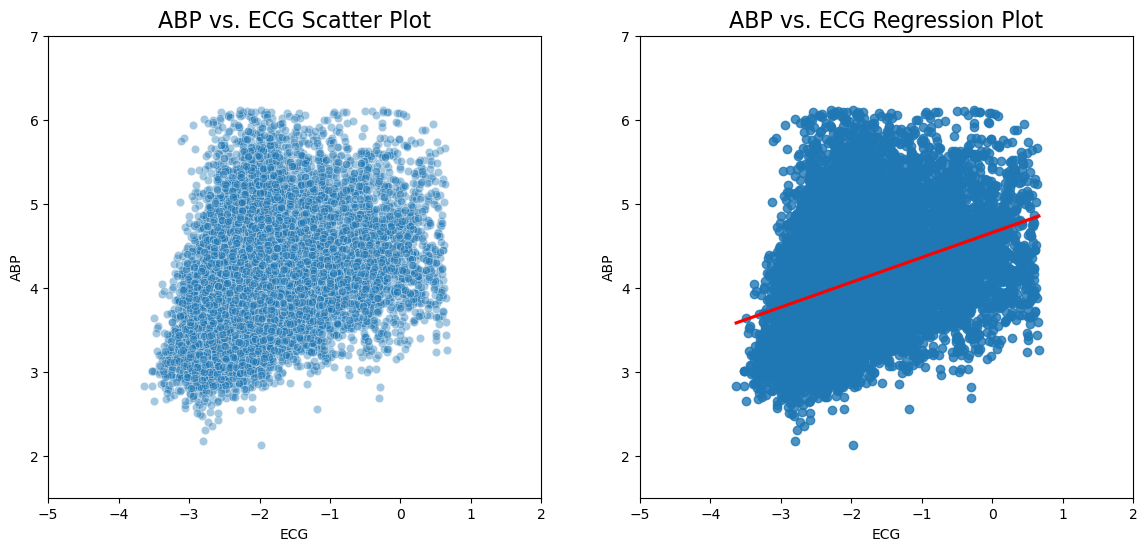

In [9]:
# Take log of data values for a more informative scatter plot
dtw_df_log = pd.DataFrame(columns=['ECG','ABP'], data=zip(np.log(dtw_df['ECG']), np.log(dtw_df['ABP'])))
# dtw_df_log = pd.DataFrame(columns=['ECG','ABP'], data=zip(dtw_df['ECG'], np.log(dtw_df['ABP'])))
print(f'Log data frame shape with outliers: {dtw_df_log.shape}')

# Remove -inf values since taking log of zero is undefined
dtw_df_log = dtw_df_log.iloc[np.where(np.isfinite(dtw_df_log['ABP'])==True)]


# Remove Z-score above 3 (99.7%) from ECG
z = np.abs(stats.zscore(dtw_df_log['ECG']))
dtw_df_log = dtw_df_log.iloc[np.where(z < 3)]

z = np.abs(stats.zscore(dtw_df_log['ABP']))
dtw_df_log = dtw_df_log.iloc[np.where(z < 3)]

print(f'Log data frame shape without outliers: {dtw_df_log.shape}')
display(dtw_df_log.head())

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0] = sns.scatterplot(x=dtw_df_log['ECG'], y=dtw_df_log['ABP'], alpha=0.4, ax=ax[0])
ax[0].set_xlim(-5, 2)
ax[0].set_ylim(1.5, 7)
ax[0].set_title('ABP vs. ECG Scatter Plot', fontsize=16)

# sns.scatterplot(x='ECG', y='ABP', data=dtw_df_log, alpha=.4)
dtw_df_log = dtw_df_log
ax[1] = sns.regplot(x='ECG', y='ABP', data=dtw_df_log, ax=ax[1], line_kws={"color": "red"})
ax[1].set_xlim(-5, 2)
ax[1].set_ylim(1.5, 7)
ax[1].set_title('ABP vs. ECG Regression Plot', fontsize=16)
plt.show()

In [10]:
rho, p = spearmanr(dtw_df_log['ECG'], dtw_df_log['ABP'])
print(f'Correlation {rho}, p-value {p}')

Correlation 0.40600593807403407, p-value 0.0


### Find outliers

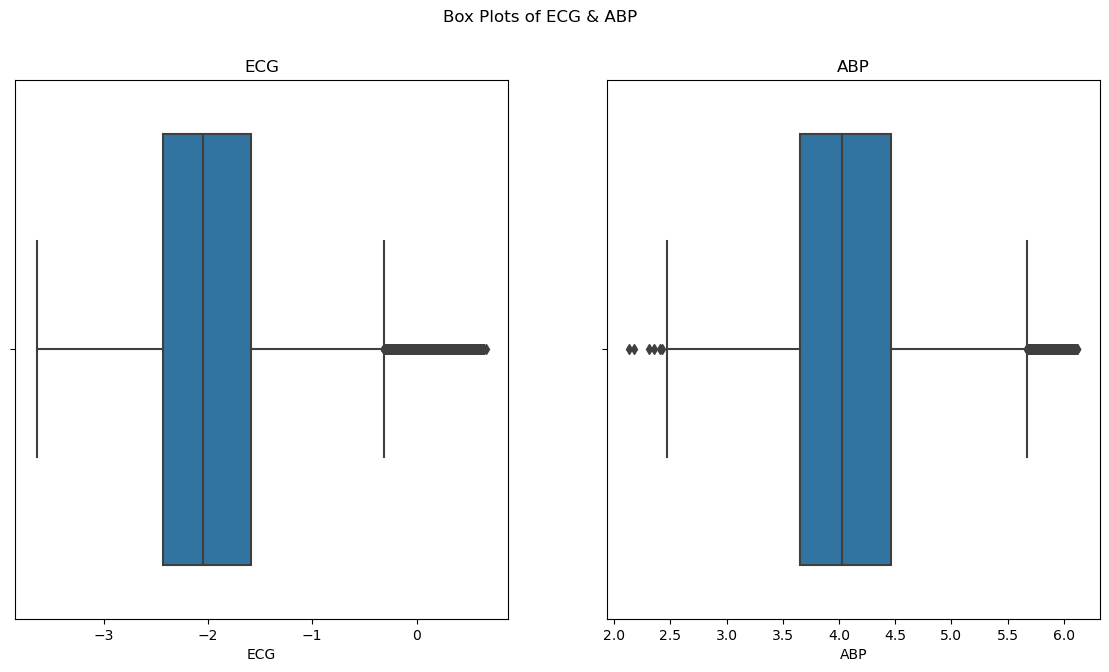

Number of ECG outliers above -0.5: 1139
[  194   195   202 ... 15764 15766 15767]
Number of ABP outliers above 5.5: 420
[   25   149   161   221   296   401   456   457   475   535   712   780
   781   792   795   796   810   813   826   844   868   906   907   914
   915   931   999  1000  1065  1124  1345  1346  1619  1626  1634  1644
  1653  1654  1657  1718  1719  1720  1721  1722  1731  1732  1733  1734
  1735  1736  1737  1738  1739  1740  1757  1811  1982  2045  2292  2342
  2343  2657  2723  2742  2803  2804  2858  2859  2860  2892  2893  2925
  2926  2935  2952  2953  3430  3460  3524  3525  3526  3528  3529  3580
  3581  3717  3960  3961  3966  3967  4002  4003  4004  4018  4019  4202
  4203  4241  4517  4518  4519  4562  4564  4566  4913  4945  4947  5015
  5016  5491  5492  5703  5828  6109  6186  6282  6331  6341  6459  6490
  6559  6696  6718  6719  6720  6722  6723  6942  6985  7051  7052  7056
  7057  7058  7059  7060  7061  7063  7064  7071  7072  7241  7264  7265
  72

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0] = sns.boxplot(dtw_df_log['ECG'], ax=ax[0])
ax[0].set_title('ECG')
ax[1] = sns.boxplot(dtw_df_log['ABP'], ax=ax[1])
ax[1].set_title('ABP')
fig.suptitle('Box Plots of ECG & ABP')
plt.show()

ecg_outliers = np.where(dtw_df_log['ECG'] > -0.5)[0]
abp_outliers = np.where(dtw_df_log['ABP'] > 5.5)[0]
print(f"Number of ECG outliers above -0.5: {len(ecg_outliers)}\n{ecg_outliers}")
print(f"Number of ABP outliers above 5.5: {len(abp_outliers)}\n{abp_outliers}")

def common(a,b): 
    c = [value for value in a if value in b] 
    return c

print(f'Observations outliers in ECG and EBP:\n{common(ecg_outliers, abp_outliers)}')

## Linear regression

### TS Fresh implementation

The code block below is intentionally commented it out because tsfresh took a VERY LONG time to run. We saved the results in a ts_features dataframe in a block below and read it in accordingly. 

### Load features from TS Fresh

ECG__variance_larger_than_standard_deviation  ECG__has_duplicate_max  \
0                                           0.0                     1.0   
1                                           0.0                     0.0   
2                                           0.0                     0.0   
3                                           0.0                     0.0   
4                                           0.0                     0.0   

   ECG__has_duplicate_min  ECG__has_duplicate  ECG__sum_values  \
0                     0.0                 1.0         2.814769   
1                     1.0                 1.0         2.910154   
2                     1.0                 1.0         2.964923   
3                     0.0                 1.0         3.055077   
4                     0.0                 0.0         2.580308   

   ECG__abs_energy  ECG__mean_abs_change  ECG__mean_change  \
0         1.980750              0.001641         -0.001641   
1         2.117525              0.006667          0.006667   
2         2.197710              0.001641         -0.001641   
3         2.333493              0.005026          0.005026   
4         1.673536              0.041641          0.041641   

   ECG__mean_second_derivative_central  ECG__median  ...  \
0                            -0.001231     0.704923  ...   
1                             0.002462     0.725077  ...   
2                             0.001231     0.740000  ...   
3                            -0.001154     0.764923  ...   
4                            -0.012462     0.657538  ...   

   ABP__ratio_beyond_r_sigma__r_10  ABP__count_above__t_0  \
0                              0.0                    1.0   
1                              0.0                    1.0   
2                              0.0                    1.0   
3                              0.0                    1.0   
4                              0.0                    1.0   

   ABP__count_below__t_0  ABP__lempel_ziv_complexity__bins_2  \
0                    0.0                                0.75   
1                    0.0                                0.75   
2                    0.0                                0.75   
3                    0.0                                0.75   
4                    0.0                                0.75   

   ABP__lempel_ziv_complexity__bins_3  ABP__lempel_ziv_complexity__bins_5  \
0                                0.75                                 1.0   
1                                0.75                                 1.0   
2                                0.75                                 1.0   
3                                0.75                                 1.0   
4                                0.75                                 1.0   

   ABP__lempel_ziv_complexity__bins_10  ABP__lempel_ziv_complexity__bins_100  \
0                                  1.0                                   1.0   
1                                  1.0                                   1.0   
2                                  1.0                                   1.0   
3                                  1.0                                   1.0   
4                                  1.0                                   1.0   

   ABP__permutation_entropy__dimension_3__tau_1  \
0                                          -0.0   
1                                          -0.0   
2                                          -0.0   
3                                          -0.0   
4                                          -0.0   

   ABP__permutation_entropy__dimension_4__tau_1  
0                                          -0.0  
1                                          -0.0  
2                                          -0.0  
3                                          -0.0  
4                                          -0.0  

[5 rows x 460 columns]

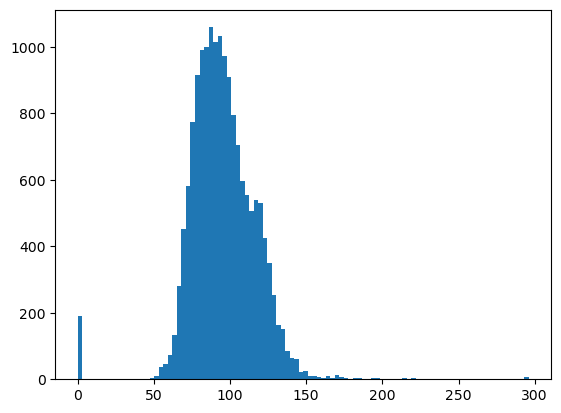

In [12]:
# Load features from TS Fresh
ts_features = pd.read_csv('D:/cardiac_data/ts_features.csv', index_col = 0)

# tsfresh may produce NAN values - impute function adds mean of feature column 
ts_features = ts_features.fillna(ts_features.mean(axis=1))
ts_features.dropna(axis=1, how='all', inplace=True)

mean_abp = [] # label for regression
for i in range(abp_df.shape[0]):
    mean_abp.append(np.mean(abp_df.loc[i])) # iterating through every 5 minute window to calculate ABP mean

plt.hist(mean_abp, bins = 100)

ecg_features = ts_features.loc[:, ts_features.columns.str.startswith('ECG')] # picking only ECG features from tsfresh
display(ts_features.head())

## Train and test datasets

In [13]:
# Finalize missing values
for i in ecg_features.columns[ecg_features.isnull().any(axis=0)]:
    ecg_features[i] = ecg_features[i].replace([np.inf, -np.inf], np.nan)
    col_mean = np.nanmean(list(ecg_features[i]))
    ecg_features[i].fillna(col_mean, inplace=True)

# create train/test split so that patients do not leak between train and test 
folds = 5 
train_array = [] 
test_array = [] 

mean_abp = np.array(mean_abp)

gss = GroupShuffleSplit(n_splits=folds, train_size=.7, random_state=42)
for i, (train_index, test_index) in enumerate(gss.split(ecg_features, mean_abp, pat_data)):
    print(f"Fold {i}:")
    print(f"  group={pat_data[train_index]}")
    print(f"   group={pat_data[test_index]}")
    train_array.append(train_index)
    test_array.append(test_index)

Fold 0:
  group=[81535 81535 81535 ... 43116 43116 43116]
   group=[70420 70420 70420 ... 72377 72377 72377]
Fold 1:
  group=[70420 70420 70420 ... 72377 72377 72377]
   group=[51858 51858 51858 ... 95088 95088 95088]
Fold 2:
  group=[81535 81535 81535 ... 72377 72377 72377]
   group=[70420 70420 70420 ... 43116 43116 43116]
Fold 3:
  group=[81535 81535 81535 ... 72377 72377 72377]
   group=[70420 70420 70420 ... 89909 89909 89909]
Fold 4:
  group=[81535 81535 81535 ... 50302 50302 50302]
   group=[70420 70420 70420 ... 72377 72377 72377]


## Random forest

In [14]:
mae_array, rmse_array = [], []

# running through each fold (indicies of training and testing saved in train_array and test_array)
# computing mean squared error and root mean squared error as metrics 

for i in range(folds):
    regr = RandomForestRegressor(max_depth=6, random_state=0, n_jobs = 10) # change n_jobs to # cores available 
    regr.fit(ecg_features.loc[train_array[i]], mean_abp[train_array[i]])
    preds = regr.predict(ecg_features.loc[test_array[i]])
    mae_array.append(MAE(preds, mean_abp[test_array[i]]))
    rmse_array.append(MSE(preds, mean_abp[test_array[i]], squared = False))
    
metrics = pd.DataFrame()
metrics['Fold'] = [1, 2, 3, 4, 5]
metrics['MAE'] = mae_array
metrics['RMSE'] = rmse_array
display(metrics)

print('Average MAE : ', metrics['MAE'].mean())
print('Standard Deviation of MAE : ', metrics['MAE'].std())
print('Average RMSE : ', metrics['RMSE'].mean())
print('Standard Deviation of RMSE : ', metrics['RMSE'].std())

Fold        MAE       RMSE
0     1  22.930295  30.456346
1     2  13.443160  16.996505
2     3  17.068127  22.926762
3     4  14.804989  19.864432
4     5  17.265105  21.814621

Average MAE :  17.102334954828894
Standard Deviation of MAE :  3.6283653825124382
Average RMSE :  22.411733267457915
Standard Deviation of RMSE :  5.02869357869896


## Xgboost

#### Model function and dataset definition (GPU)

In [15]:
@jit(target_backend='cuda')
def run_xgb_model(train, test, labels, verbose=True, iterations=100,
              n_estimators = 600, max_depth = 2,
              colsample_bylevel = .1, colsample_bytree = .1,
              learning_rate = 0.011, reg_lambda = 0.15):

    if verbose:
        print(f'Running model:\n\titerations {iterations}\n\tn_estimators={n_estimators} \
              \n\tmax_depth={max_depth}\n\tcolsample_bylevel={colsample_bylevel} \
              \n\tcolsample_bytree={colsample_bytree}\n\tlearning_rate={learning_rate} \
              \n\treg_lambda={reg_lambda}')
    
    train_data = train
    test_data = test
    train_output = labels

    xgb_model = xgb.XGBRegressor(objective ='reg:squarederror',
                             n_estimators=n_estimators, max_depth=max_depth,
                              colsample_bylevel=colsample_bylevel, colsample_bytree=colsample_bytree,
                              learning_rate=learning_rate, reg_lambda=reg_lambda , 
                              tree_method='gpu_hist')

    xgb_model.fit(train_data, train_output)
    
    preds = xgb_model.predict(test_data)

    return preds

def get_best_rmse(df):
    return df[df['rmse']==df['rmse'].min()]

train_data = ecg_features.loc[train_array[i]]
train_data_labels = mean_abp[train_array[i]]
test_data = ecg_features.loc[test_array[i]]
test_labels = mean_abp[test_array[i]]

### Find best n_estimators

In [16]:
"""
Find best n_estimators based on accuracy
"""
df = pd.DataFrame(columns=['n_estimator', 'rmse', 'mae'])
for idx, n_estimator in enumerate(np.arange(50, 1050, step=50)):
    preds = run_xgb_model(train_data, test_data, train_data_labels, False, 100,
                          n_estimator)
    rmse = np.sqrt(MSE(test_labels, preds))
    mae = MAE(test_labels, preds)    
    df.loc[idx] = [n_estimator, round(rmse, 4), round(mae, 4)]
    
display(get_best_rmse(df))
best_n_estimator = int(get_best_rmse(df)['n_estimator'].values[0])

n_estimator     rmse      mae
11        600.0  21.4431  16.8051

### Find best max depth

In [17]:
"""
Find best max_depth based on accuracy
"""
df = pd.DataFrame(columns=['max_depth', 'rmse', 'mae'])
for idx, max_depth in enumerate(np.arange(2, 11)):
    preds = run_xgb_model(train_data, test_data, train_data_labels, False, 100,
                          best_n_estimator, max_depth)
    rmse = np.sqrt(MSE(test_labels, preds))
    mae = MAE(test_labels, preds)    
    df.loc[idx] = [max_depth, round(rmse, 4), round(mae, 4)]

display(get_best_rmse(df))
best_max_depth = int(get_best_rmse(df)['max_depth'].values[0])

max_depth     rmse      mae
0        2.0  21.4431  16.8051

### Find best colsample_bylevel

In [18]:
"""
Find best colsample_bylevel based on accuracy
"""
df = pd.DataFrame(columns=['colsample_bylevel', 'rmse', 'mae'])
for idx, colsample_bylevel in enumerate(np.arange(.1, 1, step =.05)):
    colsample_bylevel = round(colsample_bylevel, 2)
    preds = run_xgb_model(train_data, test_data, train_data_labels, False, 100,
                          best_n_estimator, best_max_depth, colsample_bylevel)
    rmse = np.sqrt(MSE(test_labels, preds))
    mae = MAE(test_labels, preds)    
    df.loc[idx] = [str(colsample_bylevel), round(rmse, 4), round(mae, 4)]

display(get_best_rmse(df))
best_colsample_bylevel = get_best_rmse(df)['colsample_bylevel'].values[0]

colsample_bylevel     rmse      mae
0               0.1  21.4431  16.8051

### Find best colsample_bytree

In [19]:
"""
Find best colsample_bytree based on accuracy
"""
df = pd.DataFrame(columns=['colsample_bytree', 'rmse', 'mae'])
for idx, colsample_bytree in enumerate(np.arange(.1, 1, step =.05)):
    colsample_bylevel = round(colsample_bylevel, 2)
    preds = run_xgb_model(train_data, test_data, train_data_labels, False, 100,
                          best_n_estimator, best_max_depth, best_colsample_bylevel,
                          colsample_bytree)
    rmse = np.sqrt(MSE(test_labels, preds))
    mae = MAE(test_labels, preds)
    df.loc[idx] = [str(colsample_bytree), round(rmse, 4), round(mae, 4)]

display(get_best_rmse(df))
best_colsample_bytree = get_best_rmse(df)['colsample_bytree'].values[0]

colsample_bytree     rmse      mae
0              0.1  21.4431  16.8051

### Find best learning rate

In [20]:
"""
Find best learning_rate based on accuracy
"""
learning_rates = np.arange(0.01, .02, step=.001)
# learning_rates = np.append(learning_rates, .01) # Include a small value for validation
learning_rates = sorted(learning_rates)
    
df = pd.DataFrame(columns=['learning_rate', 'rmse', 'mae'])
for idx, learning_rate in enumerate(learning_rates):
    learning_rate = round(learning_rate, 4)
    preds = run_xgb_model(train_data, test_data, train_data_labels, False, 100,
                          best_n_estimator, best_max_depth, best_colsample_bylevel, 
                          best_colsample_bytree, learning_rate)
    rmse = np.sqrt(MSE(test_labels, preds))
    mae = MAE(test_labels, preds)
    df.loc[idx] = [str(learning_rate), round(rmse, 4), round(mae, 4)]

display(get_best_rmse(df))
best_learning_rate = get_best_rmse(df)['learning_rate'].values[0]    

learning_rate     rmse      mae
2         0.012  21.4366  16.8075

### Find best reg lambda

In [21]:
"""
Find best reg_lambda based on accuracy
"""
df = pd.DataFrame(columns=['reg_lambda', 'rmse', 'mae'])
for idx, reg_lambda in enumerate(np.arange(0.05, 1, step=0.05)):
    reg_lambda = round(reg_lambda, 2)
    preds = run_xgb_model(train_data, test_data, train_data_labels, False, 100,
                          best_n_estimator, best_max_depth, best_colsample_bylevel, 
                          best_colsample_bytree, best_learning_rate, reg_lambda)
    rmse = np.sqrt(MSE(test_labels, preds))
    mae = MAE(test_labels, preds)
    df.loc[idx] = [reg_lambda, round(rmse, 4), round(mae, 4)]

display(get_best_rmse(df))
best_reg_lambda = get_best_rmse(df)['reg_lambda'].values[0]  
best_rmse = get_best_rmse(df)['rmse'].values[0]
best_mae = get_best_rmse(df)['mae'].values[0]

reg_lambda     rmse      mae
13        0.70  21.4288  16.8000
14        0.75  21.4288  16.7998

### Best XGBoost parameters and RMSE

In [22]:
print(f'Best n_estimator: {best_n_estimator}\nBest max_depth: {best_max_depth} \
        \nBest colsample_bylevel: {best_colsample_bylevel} \
        \nBest colsample_bytree: {best_colsample_bytree} \
        \nBest learning_rate: {best_learning_rate}\nBest reg_lamba: {best_reg_lambda} \
        \n\nBest RMSE: {best_rmse}\nBest MAE: {best_mae}')

Best n_estimator: 600
Best max_depth: 2         
Best colsample_bylevel: 0.1         
Best colsample_bytree: 0.1         
Best learning_rate: 0.012
Best reg_lamba: 0.7         

Best RMSE: 21.4288
Best MAE: 16.8


## Forecasting

### ARIMA

#### ARIMA on log data

In [23]:
ols_model = smf.ols(formula = 'ECG ~ ABP', data=dtw_df_log).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ECG   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     2403.
Date:                Mon, 22 May 2023   Prob (F-statistic):               0.00
Time:                        22:43:25   Log-Likelihood:                -17051.
No. Observations:               15776   AIC:                         3.411e+04
Df Residuals:                   15774   BIC:                         3.412e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7362      0.038    -99.086      0.0

#### Function to view diagnostics

In [24]:
# Create a group of plots for diagnostics 
def visualize_diagnostics(data): 
    fig = plt.figure(figsize=(20,20))
    layout = (3, 2)

    data_ax = plt.subplot2grid(layout, (0, 0), colspan=1)
    hist_ax = plt.subplot2grid(layout, (0, 1), colspan=1)
    hist_ax.set_title('Frequency of Values')
    acf_ax = plt.subplot2grid(layout, (1, 0), colspan=1)
    pacf_ax = plt.subplot2grid(layout, (1, 1), colspan=1)
    qq_ax = plt.subplot2grid(layout, (2, 0), colspan=1)
    qq_ax.set_title('Q-Q PLot')
    
    data.plot(ax=data_ax, title='Residuals')
    data.hist(ax=hist_ax)
    acf = plot_acf(data, ax=acf_ax)
    pacf = plot_pacf(data, ax=pacf_ax)
    qqplot(data, ax=qq_ax, line='q')
    
    plt.show()

#### ARIMA on reduced data

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  125
Model:                          ARIMA   Log Likelihood                 458.422
Date:                Mon, 22 May 2023   AIC                           -912.844
Time:                        22:43:25   BIC                           -907.188
Sample:                             0   HQIC                          -910.546
                                - 125                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6984      0.001   1210.707      0.000       0.697       0.700
sigma2      3.814e-05   5.96e-06      6.401      0.000    2.65e-05    4.98e-05
Ljung-Box (L1) (Q):                   5.30   Jarque-

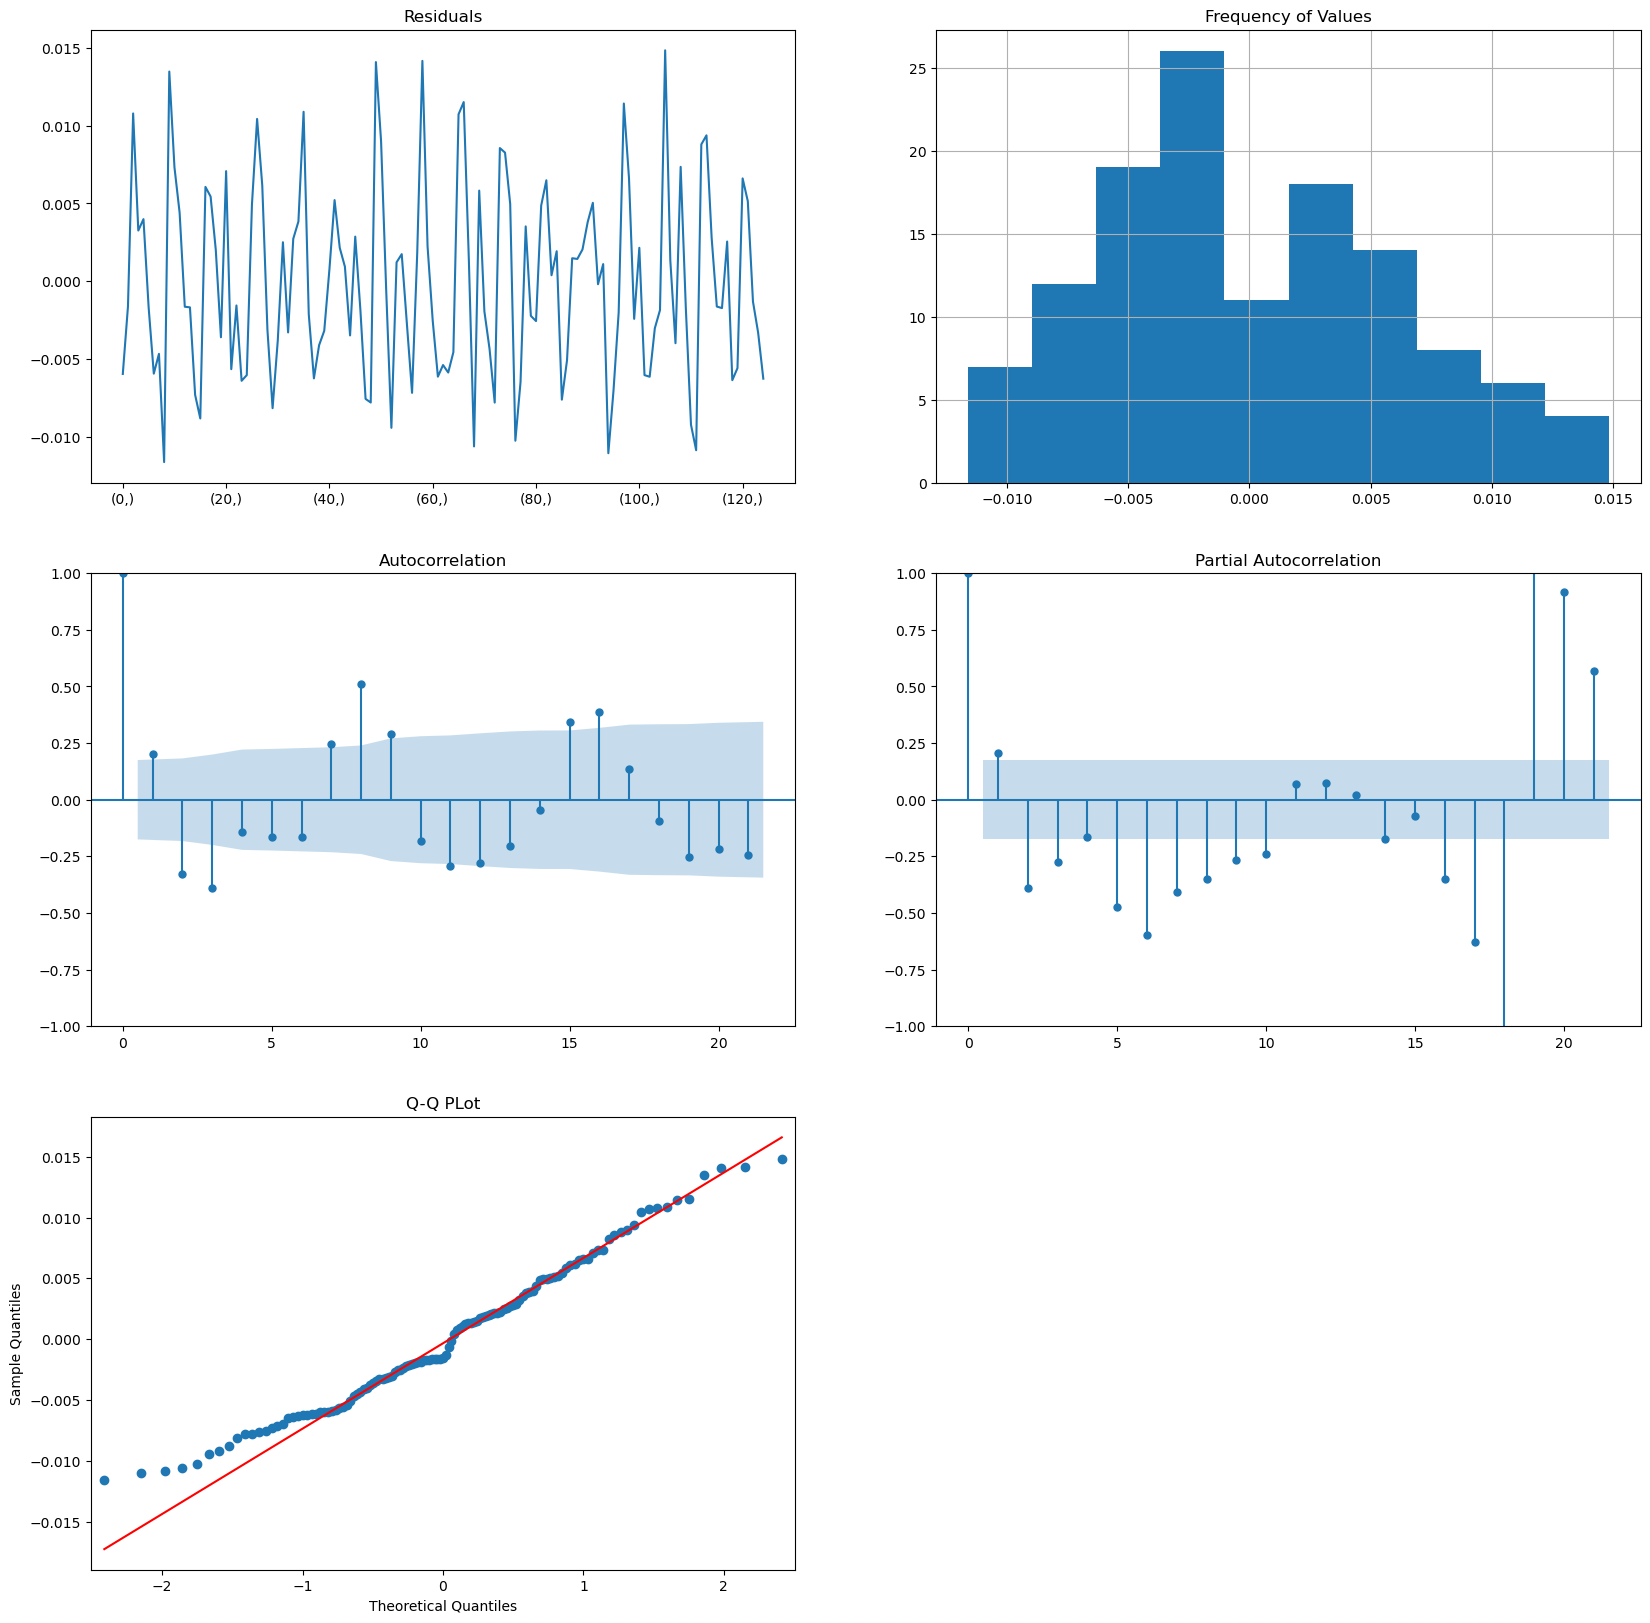

In [25]:
# Using reduced data
arima = ARIMA(ecg_subset.loc[0])
model = arima.fit()
print(model.summary())

visualize_diagnostics(model.resid)

#### ACF and PACF plots

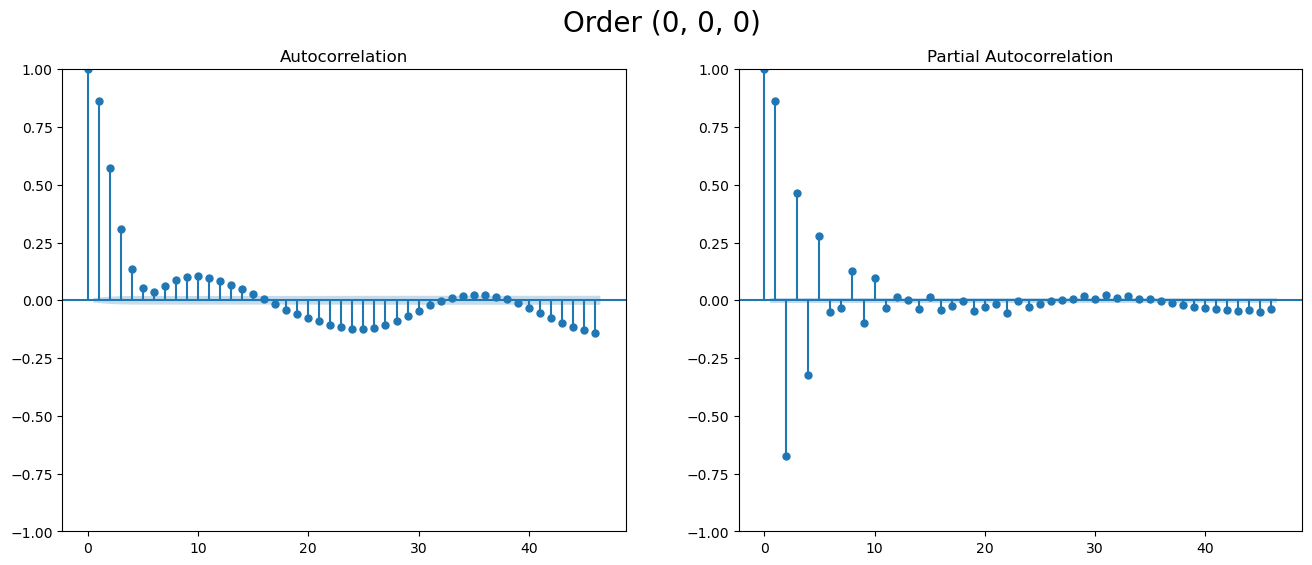

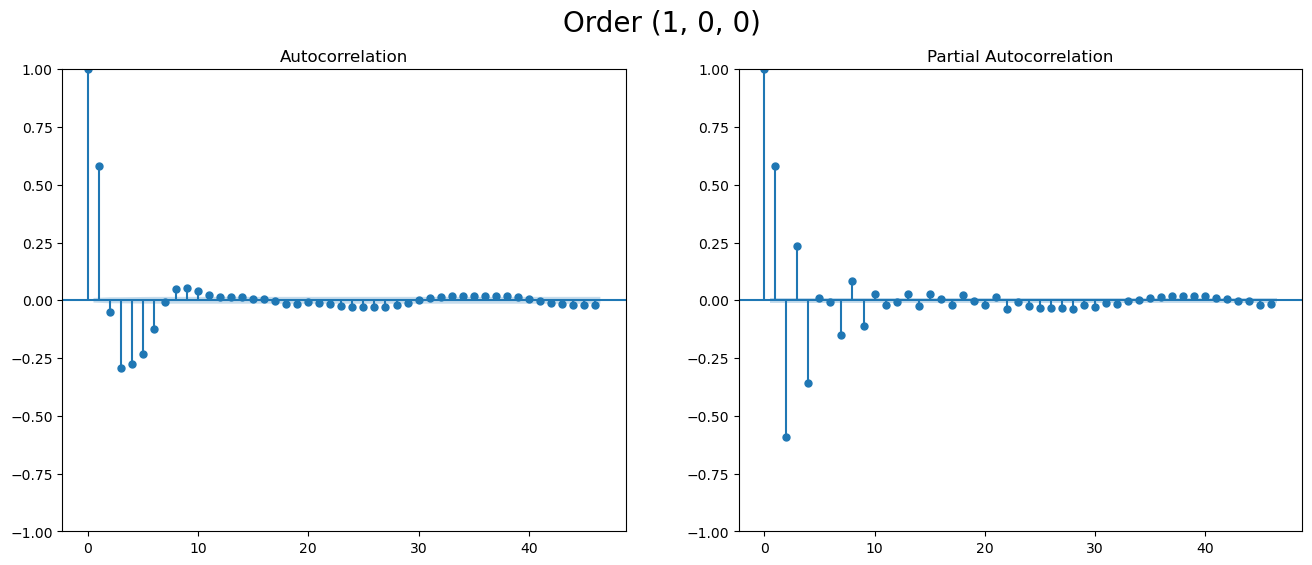

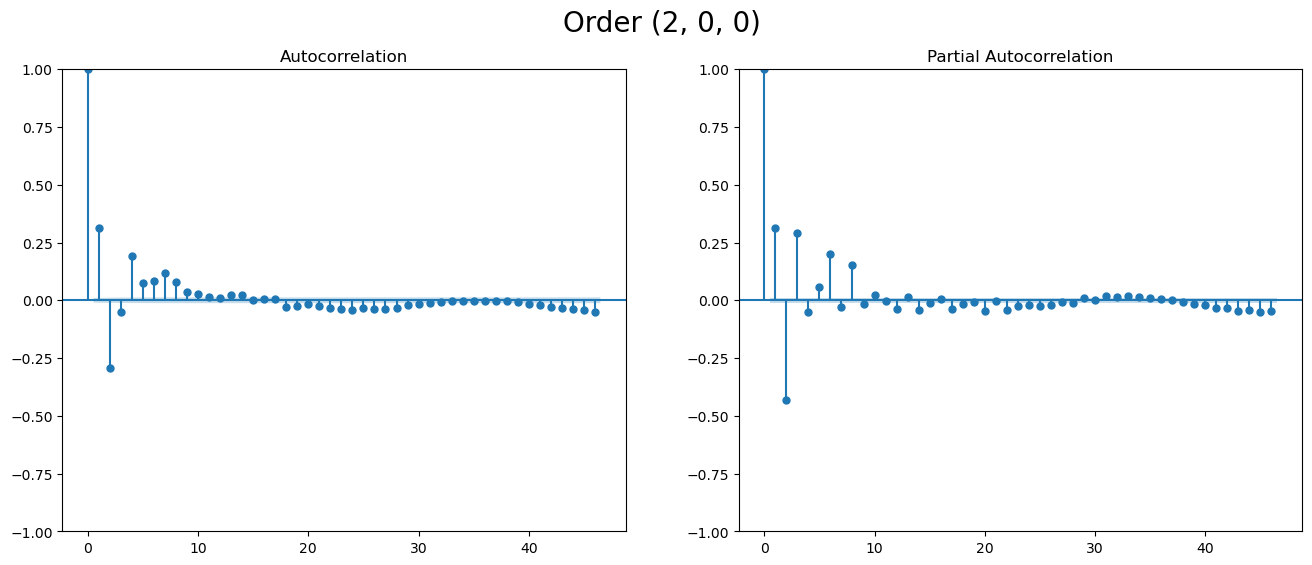

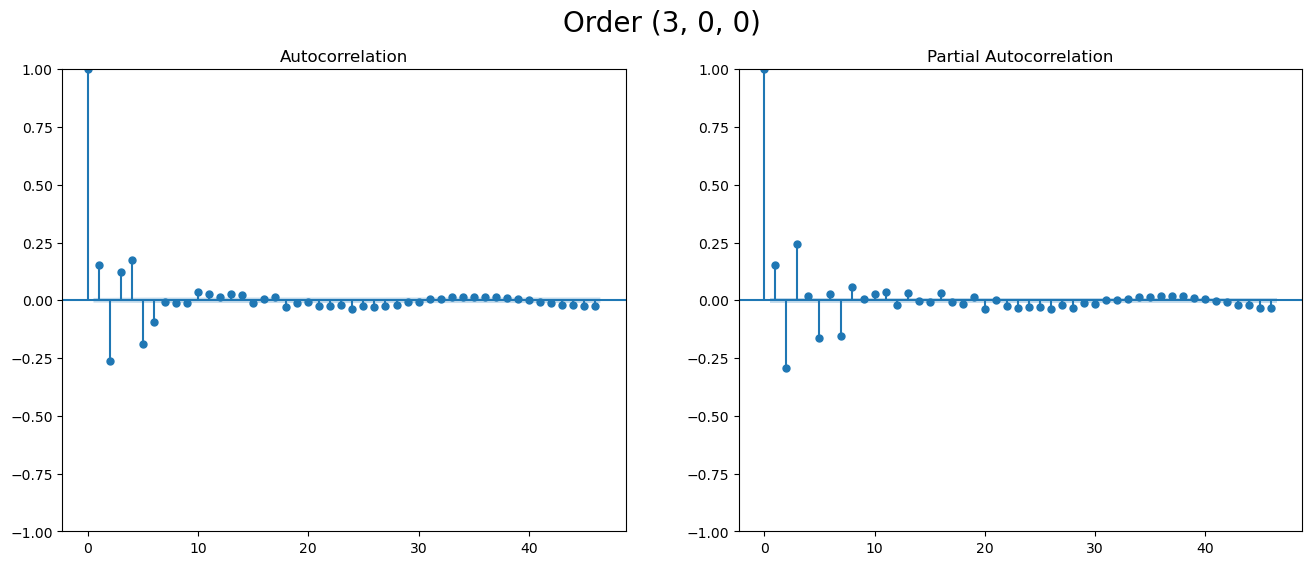

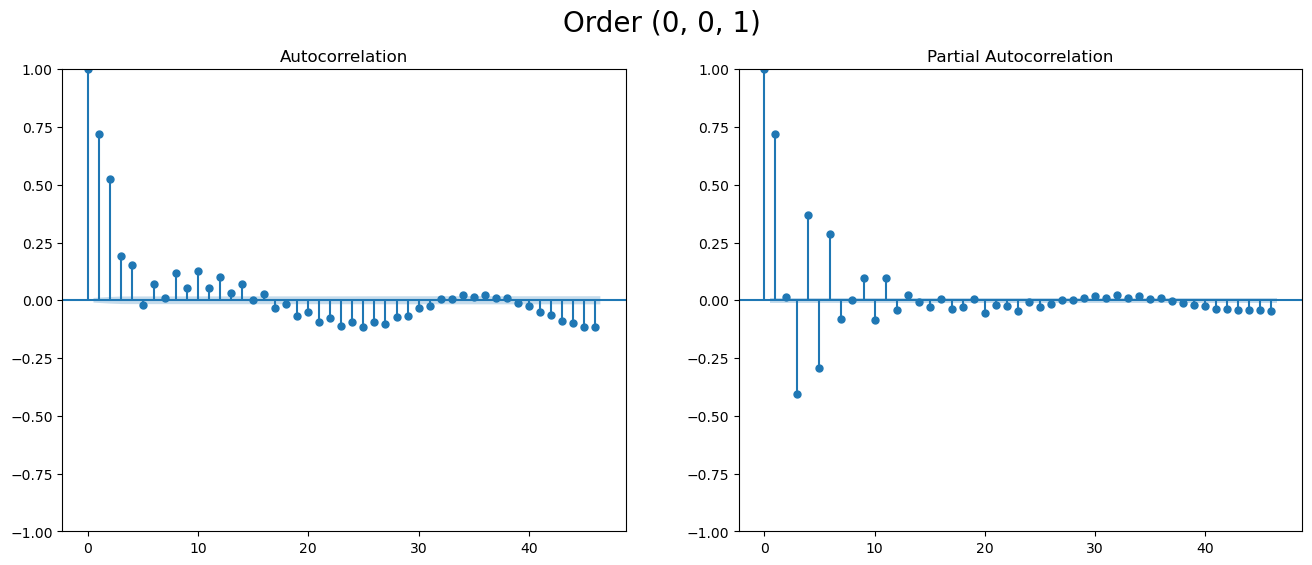

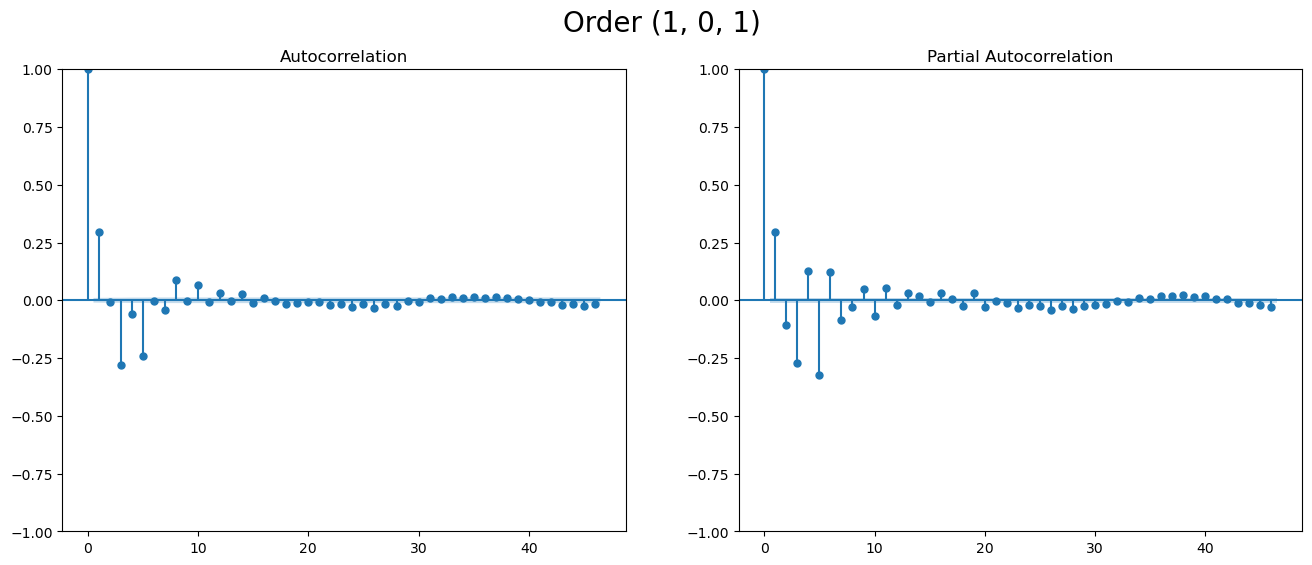

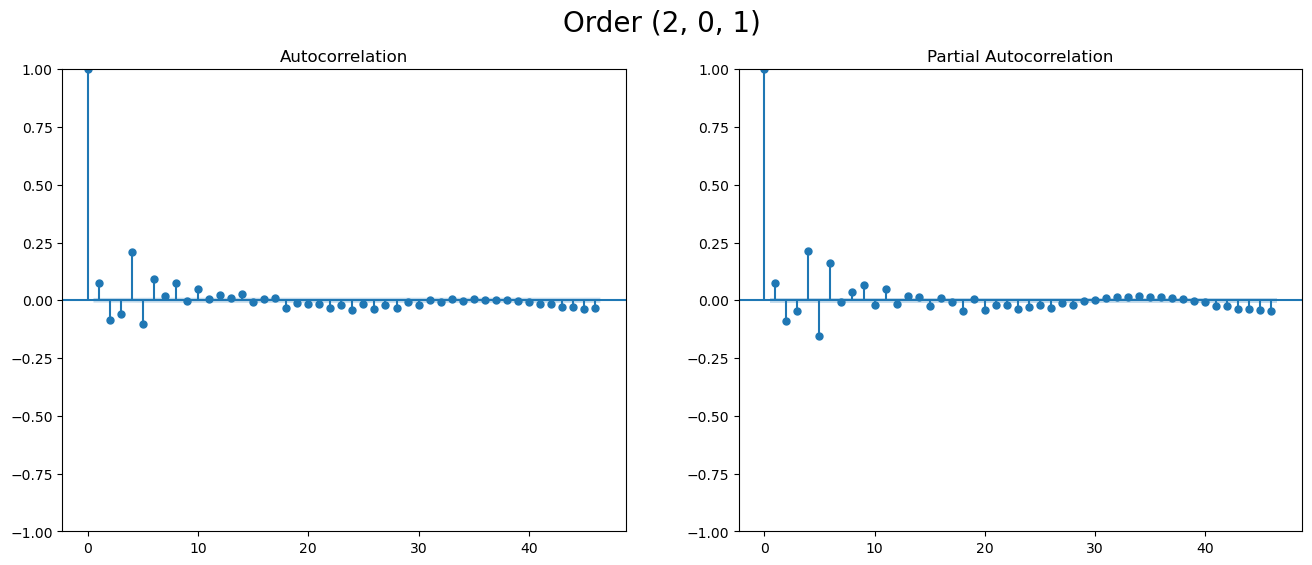

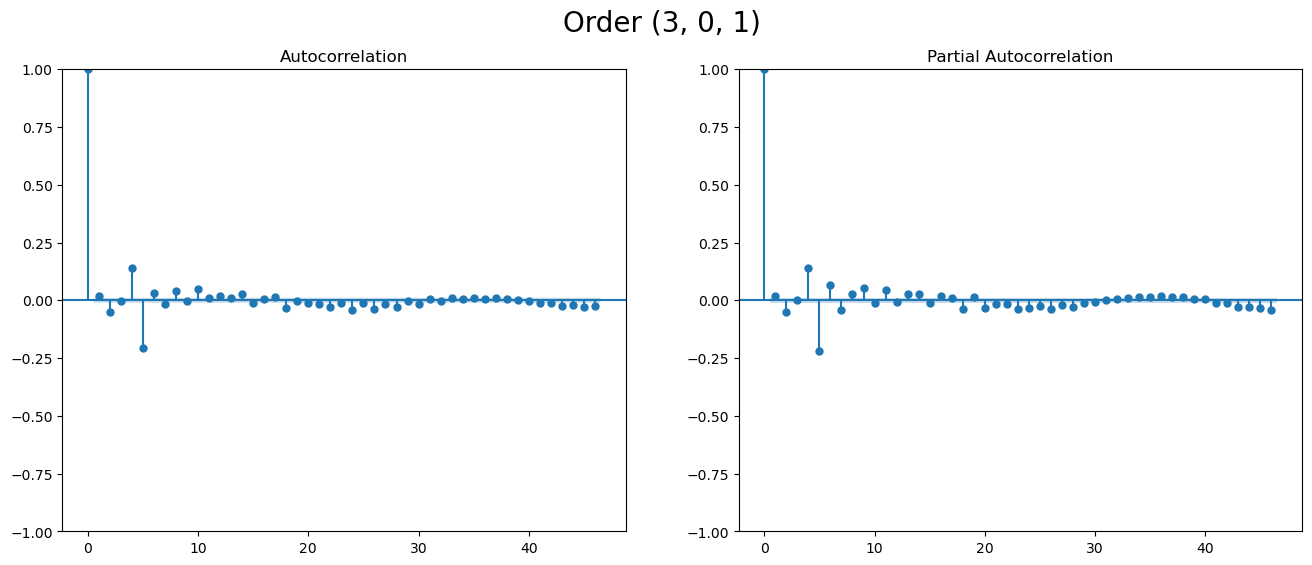

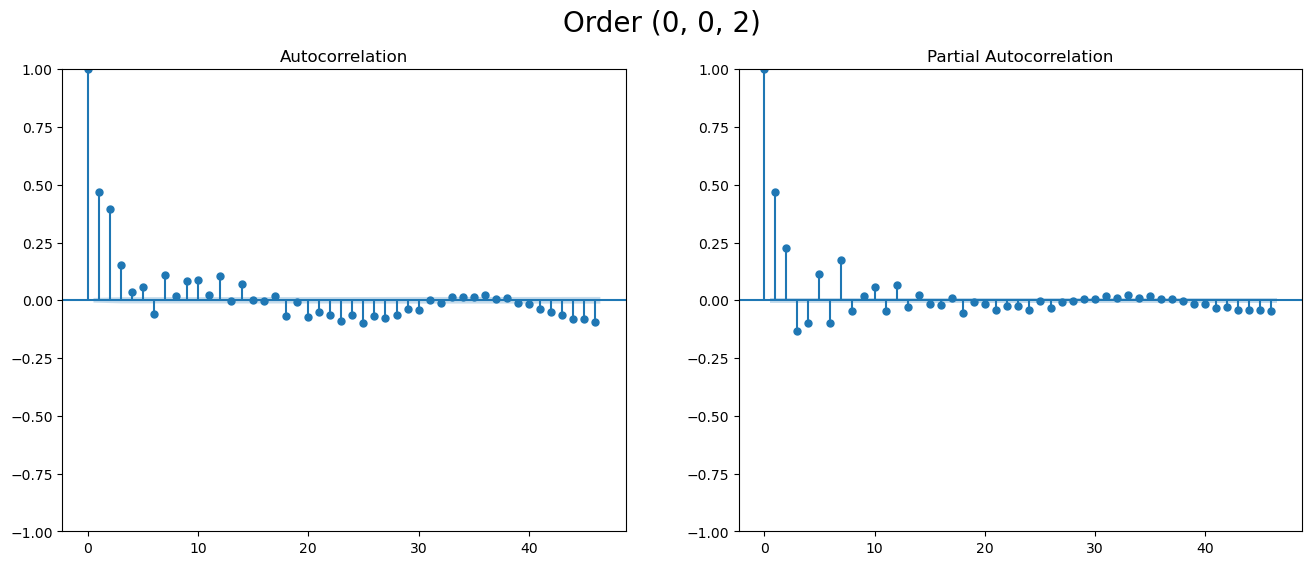

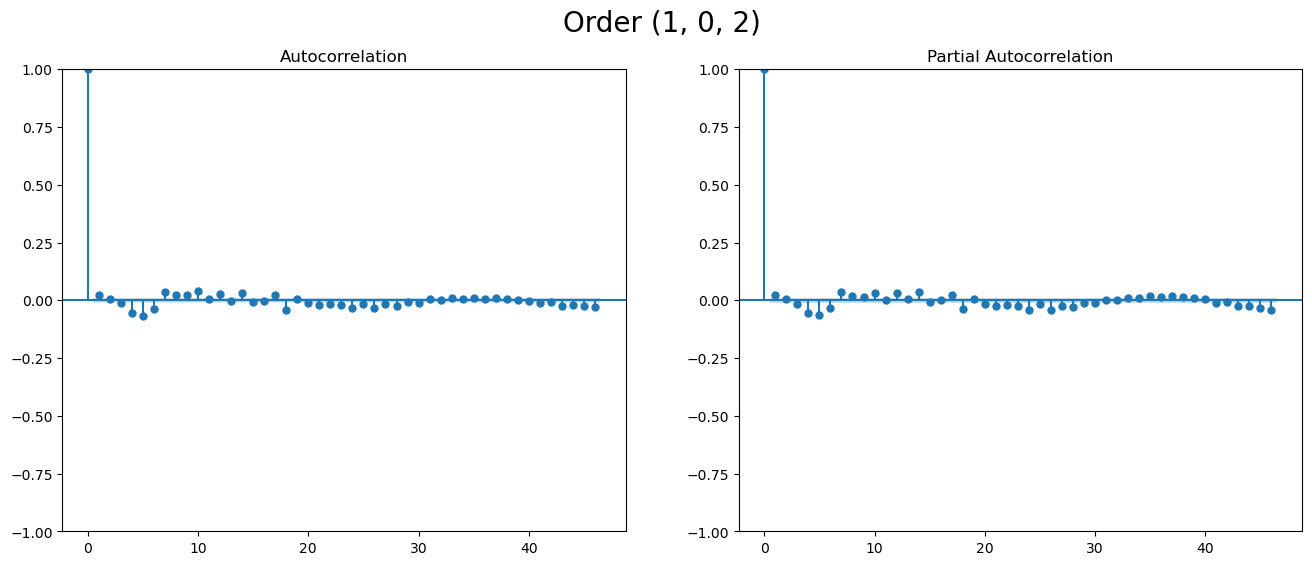

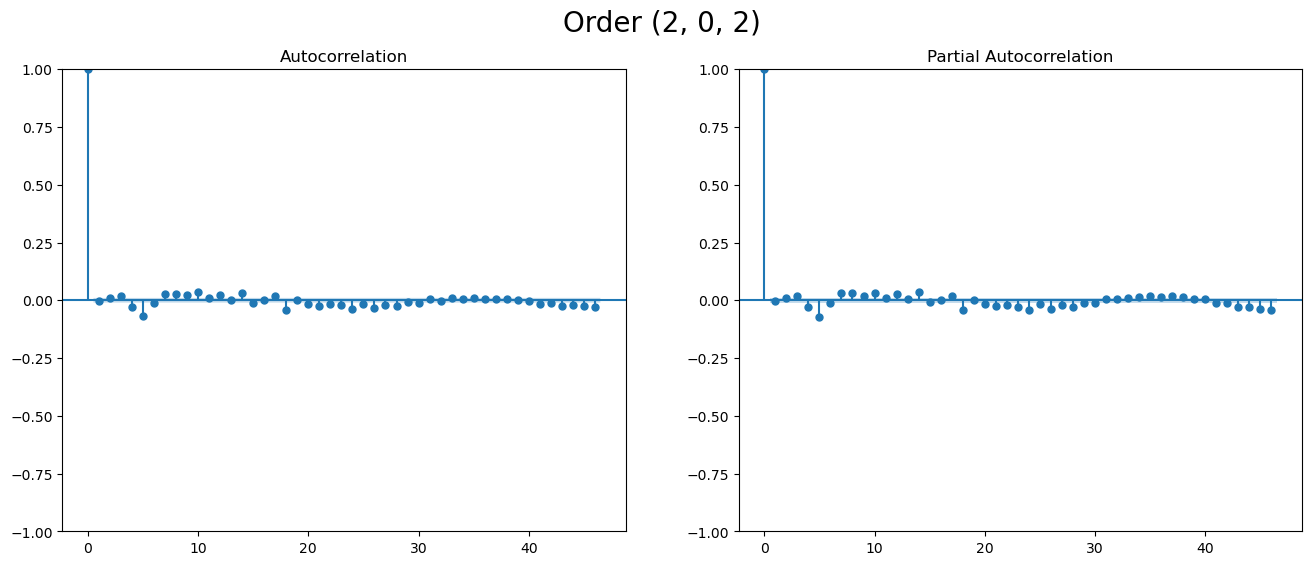

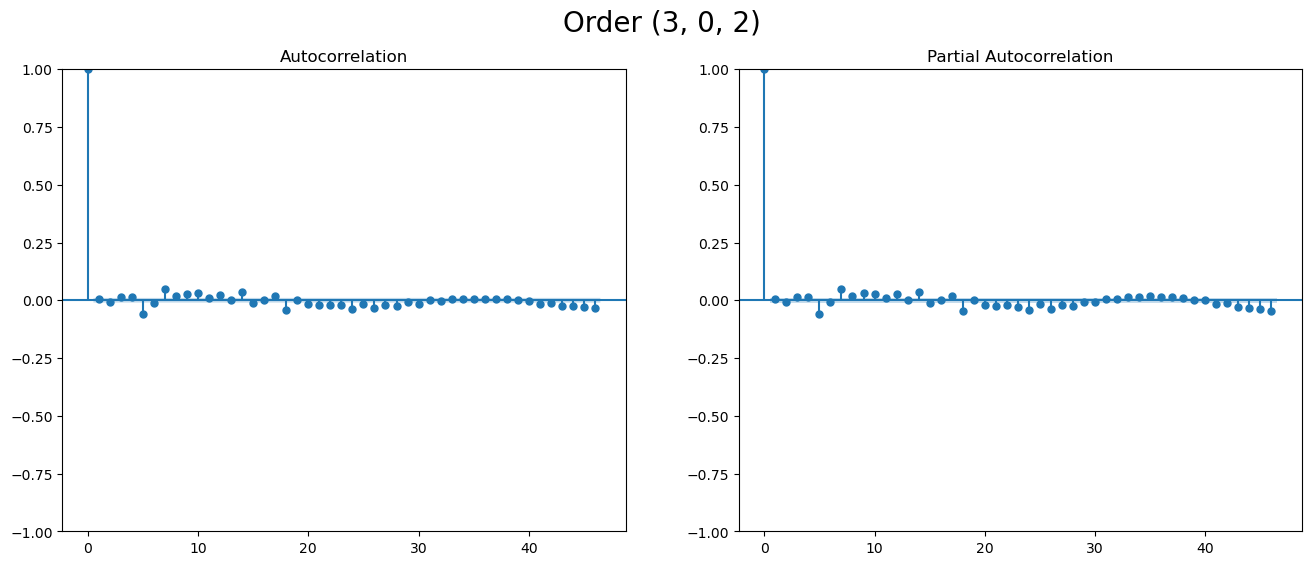

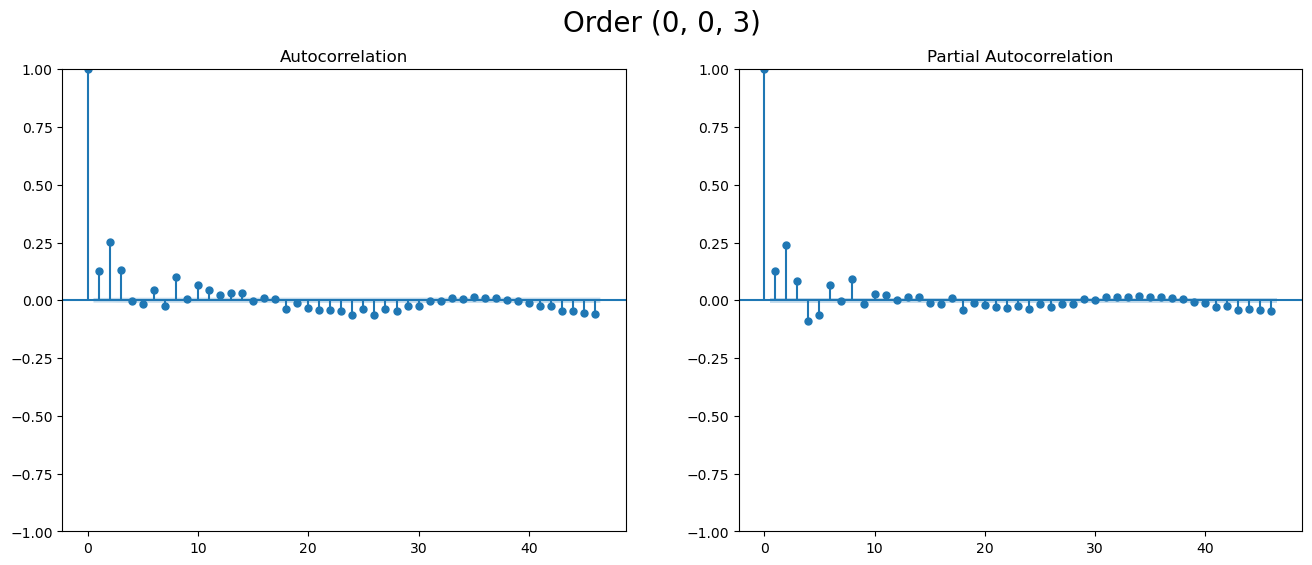

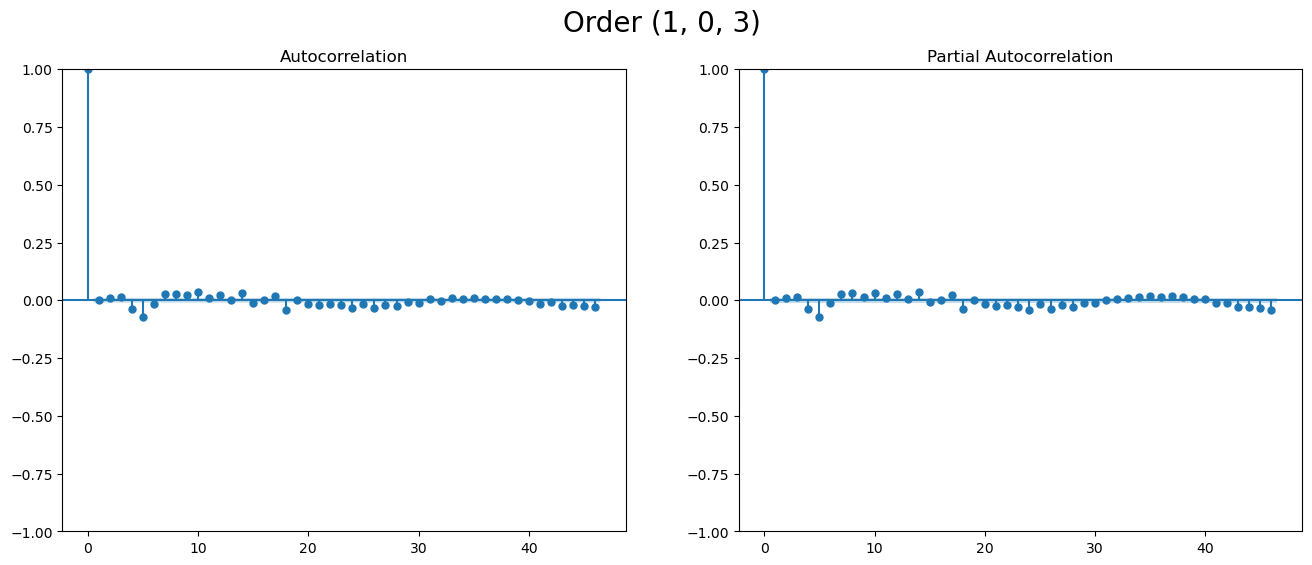

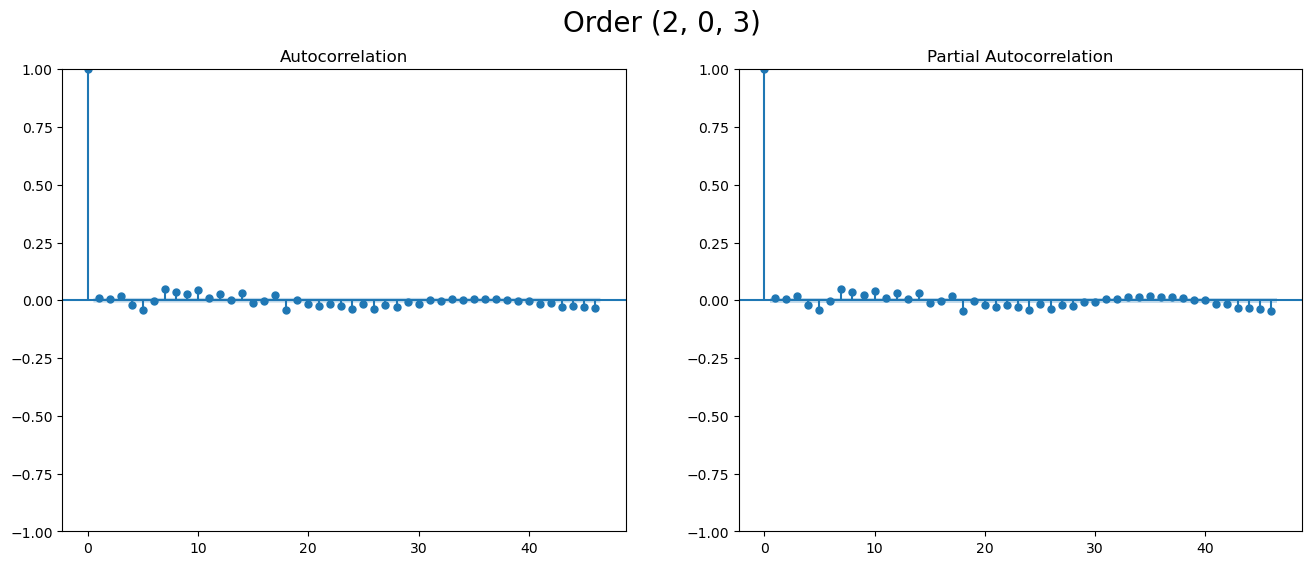

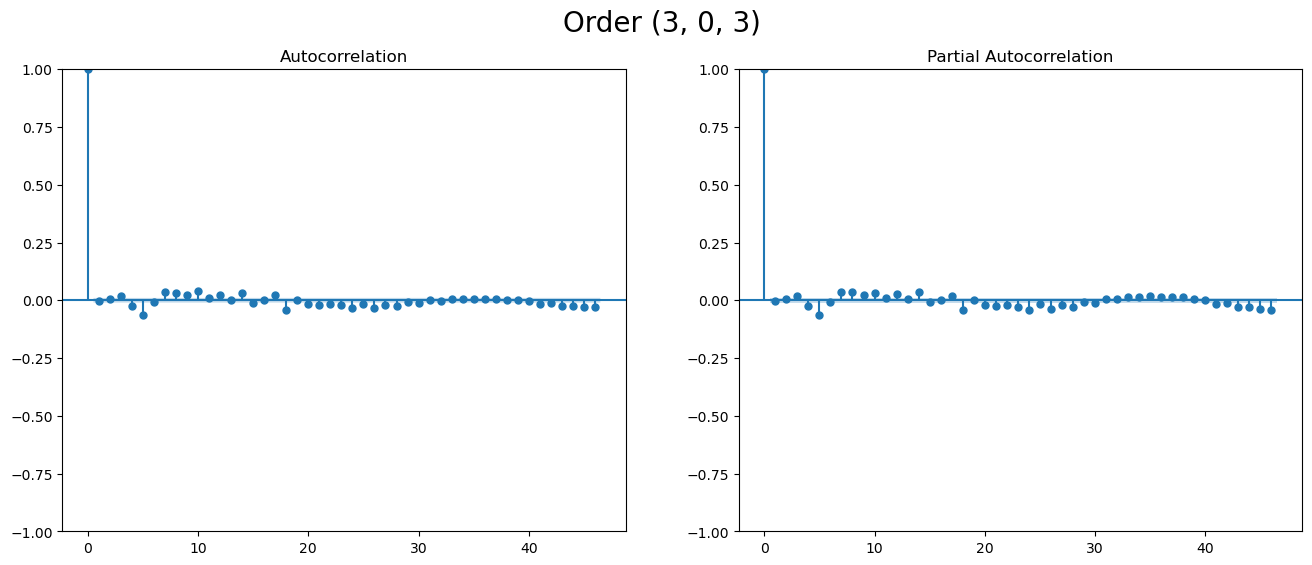

In [26]:
# Using original data

for q in range(0, 4):
    for p in range(0, 4):
        arima = ARIMA(ecg_df.loc[0], order=(p, 0, q))
        model = arima.fit()
        data = model.resid

        # Plot ACF and PCF per Order combination
        fig = plt.figure(figsize=(16, 6))
        layout = (1, 2)    
        acf_ax = plt.subplot2grid(layout, (0, 0), colspan=1)
        pacf_ax = plt.subplot2grid(layout, (0, 1), colspan=1)
        acf = plot_acf(data, ax=acf_ax)
        pacf = plot_pacf(data, ax=pacf_ax)
        plt.suptitle(f'Order ({p}, 0, {q})', fontsize=20)
        plt.show()

#### Best ARIMA with seasonality

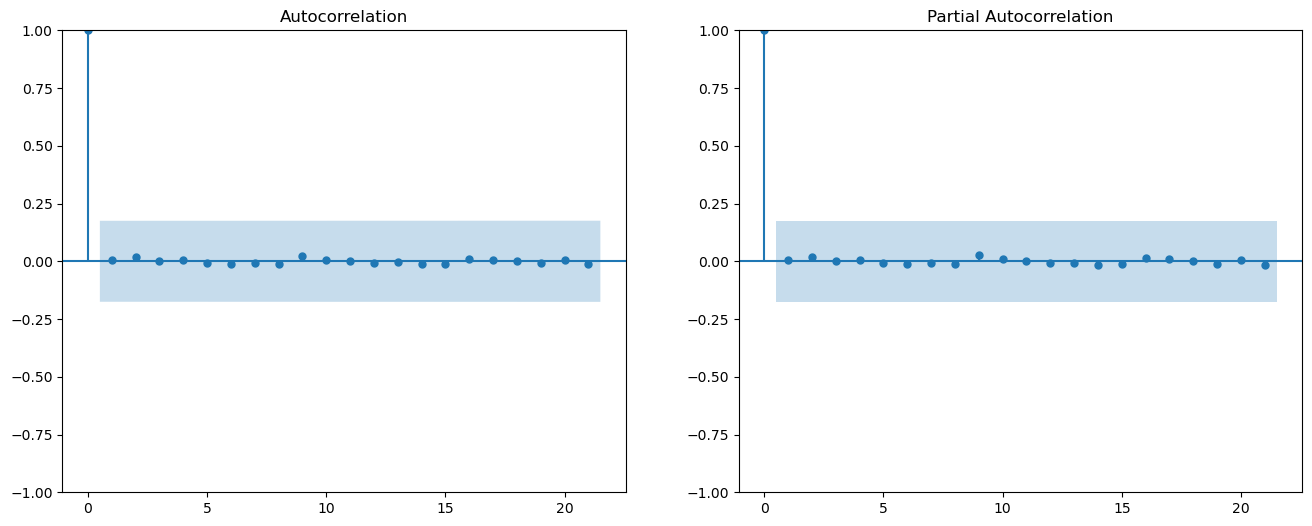

In [27]:
arima = ARIMA(ecg_subset.loc[0], order=(1, 1, 1), seasonal_order=(1, 0, 1, 20)) # Period best adjusts prediction
model = arima.fit()
data = model.resid

# Plot ACF and PCF per Order combination
fig = plt.figure(figsize=(16, 6))
layout = (1, 2)    
acf_ax = plt.subplot2grid(layout, (0, 0), colspan=1)
pacf_ax = plt.subplot2grid(layout, (0, 1), colspan=1)
acf = plot_acf(data, ax=acf_ax)
pacf = plot_pacf(data, ax=pacf_ax)
# plt.suptitle(f'Order ({p}, 0, {q})', fontsize=20)
plt.show()

In [28]:
# Find where patients break
previous_patient = pat_data[0]
curr_patient = ''
patients = []
new_patient_offsets = []
new_patient_offsets.append(0)
patients.append(previous_patient)

for idx in range(0, pat_data.shape[0]):
    curr_patient = pat_data[idx]
    if previous_patient != curr_patient:
        """
        Same patients occur multiple segments in data.
        Need to keep a list of unique patients.
        """
        if curr_patient not in patients: 
            new_patient_offsets.append(idx)
            patients.append(curr_patient)
        
    previous_patient = curr_patient
    
print(f'New patient offsets:\n{new_patient_offsets}')

New patient offsets:
[0, 301, 775, 1169, 1829, 1832, 3647, 3772, 3957, 4077, 4104, 4164, 6098, 6732, 7920, 8113, 8212, 8276, 8354, 8567, 9138, 9827, 10009, 10048, 11134, 11737, 12003, 12543, 14362, 15264, 15265, 15511, 16283]


#### ARIMA prediction

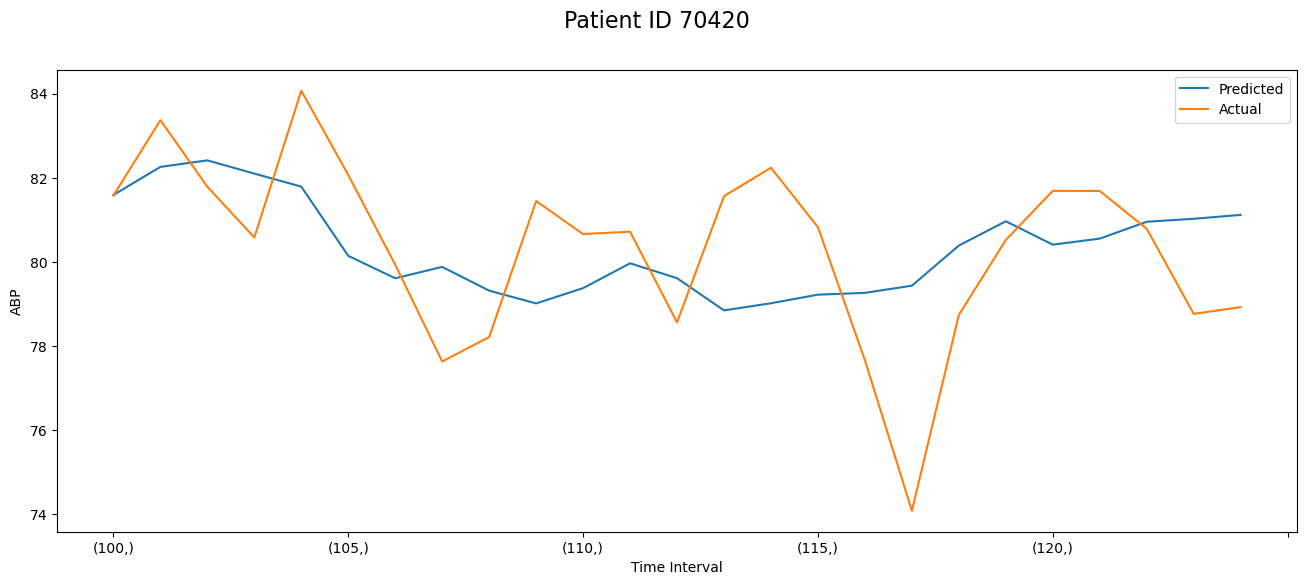

RMSE: 1.9568537669635842


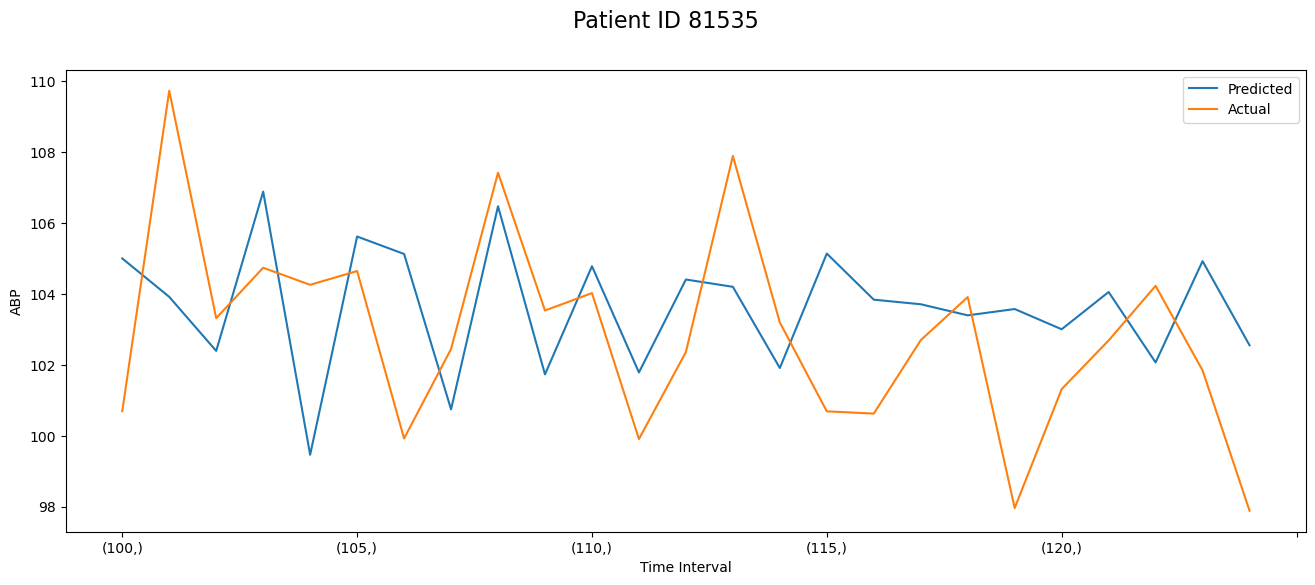

RMSE: 3.1180769410656834


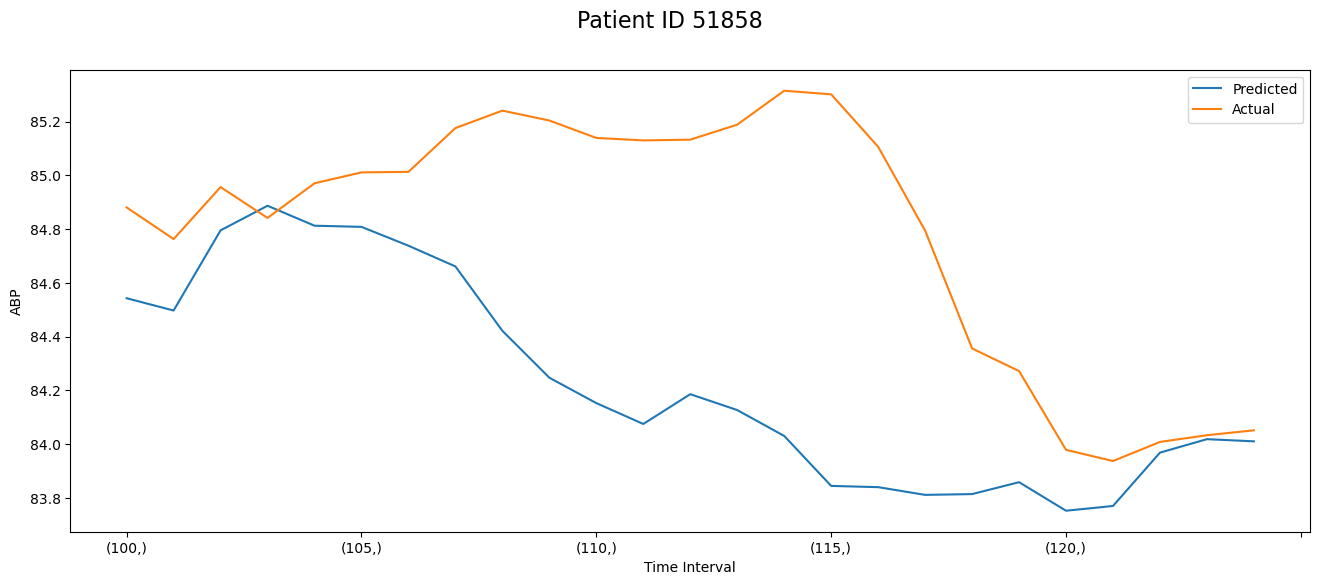

RMSE: 0.7268258957160362


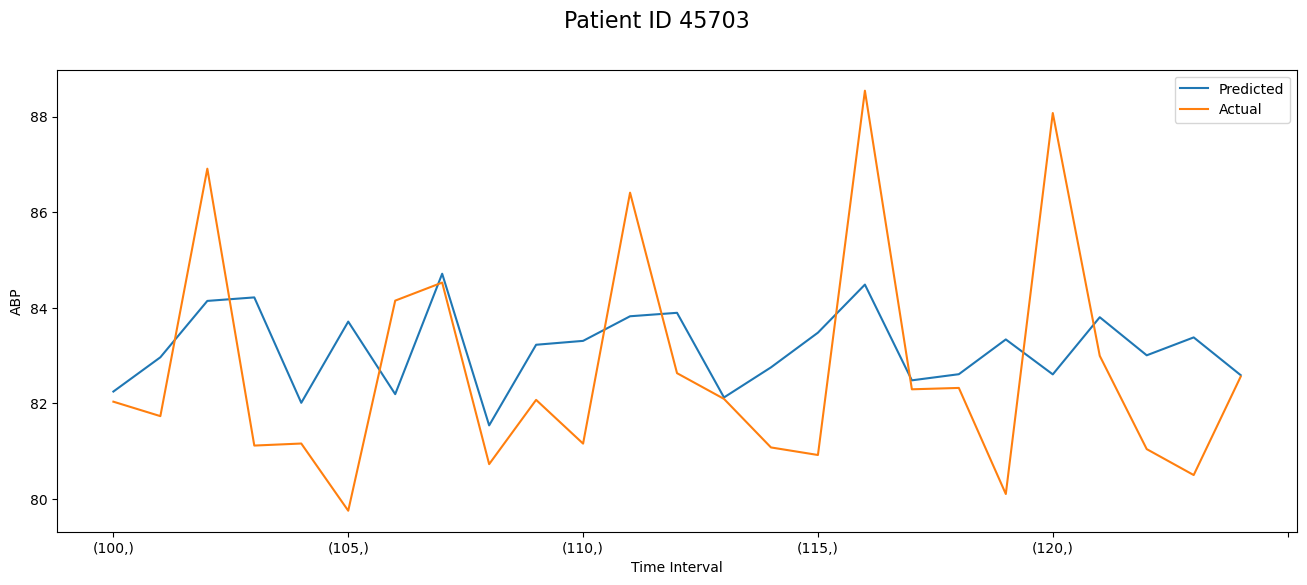

RMSE: 2.306804907547913


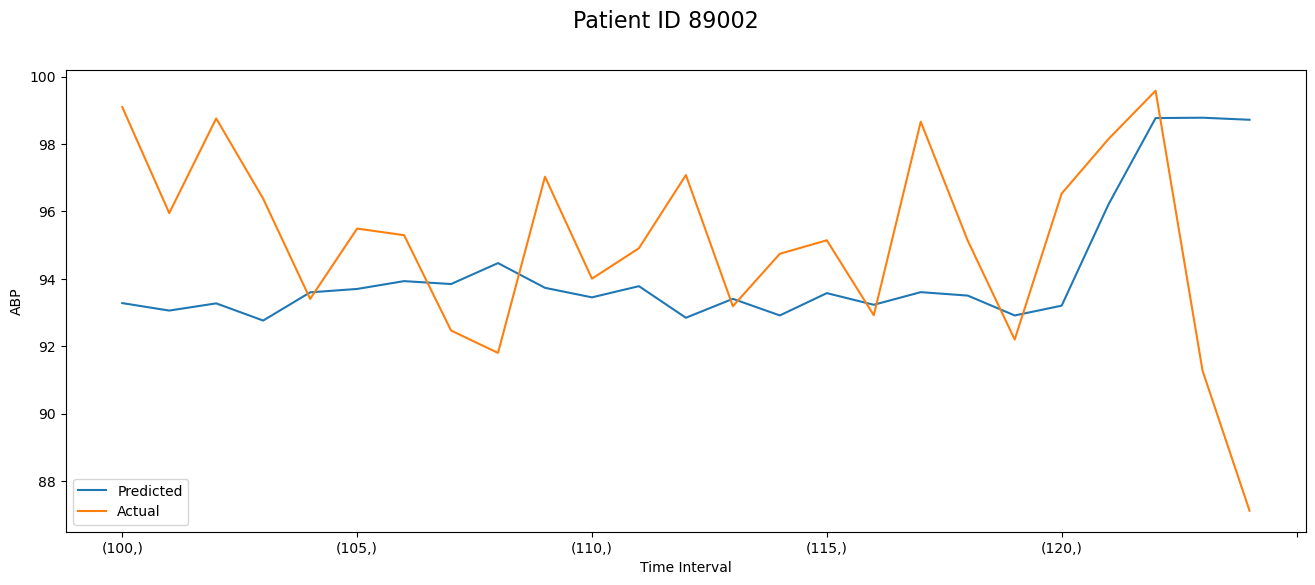

RMSE: 3.853271952863166


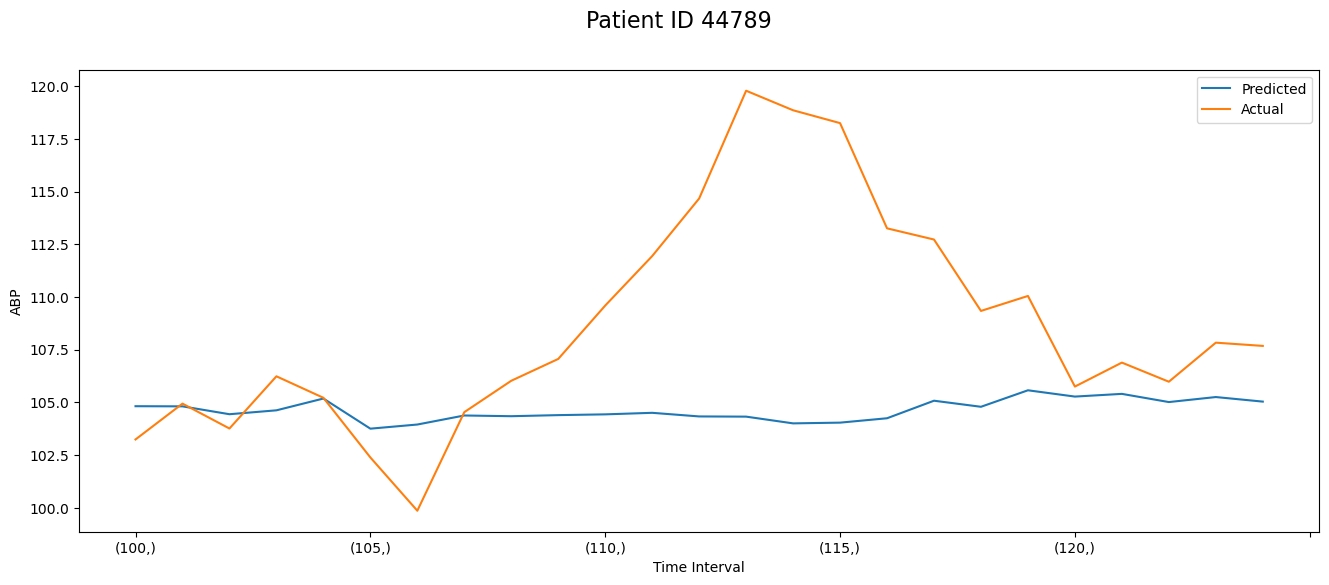

RMSE: 6.577495168107048


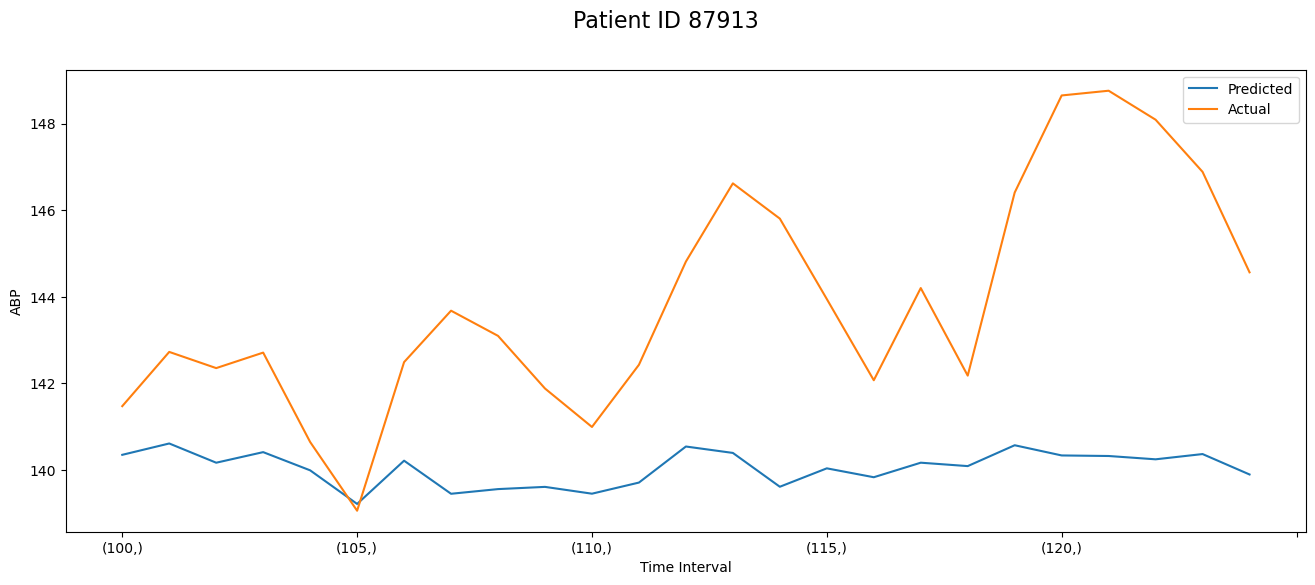

RMSE: 4.4897614481266634


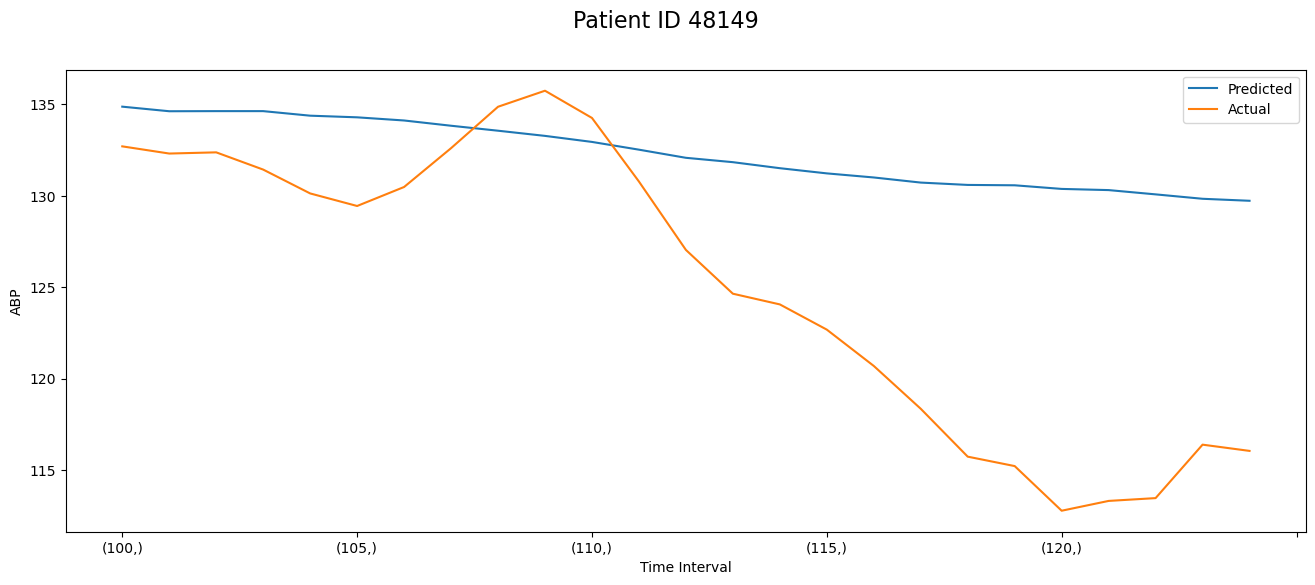

RMSE: 9.509623458959915


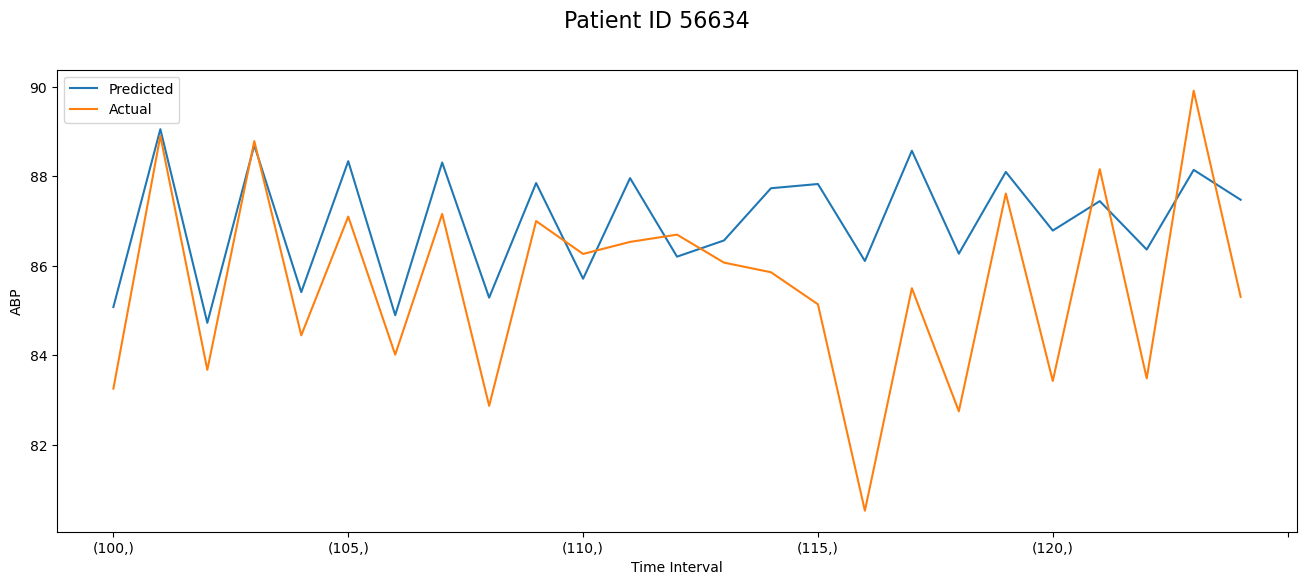

RMSE: 2.100316747407555


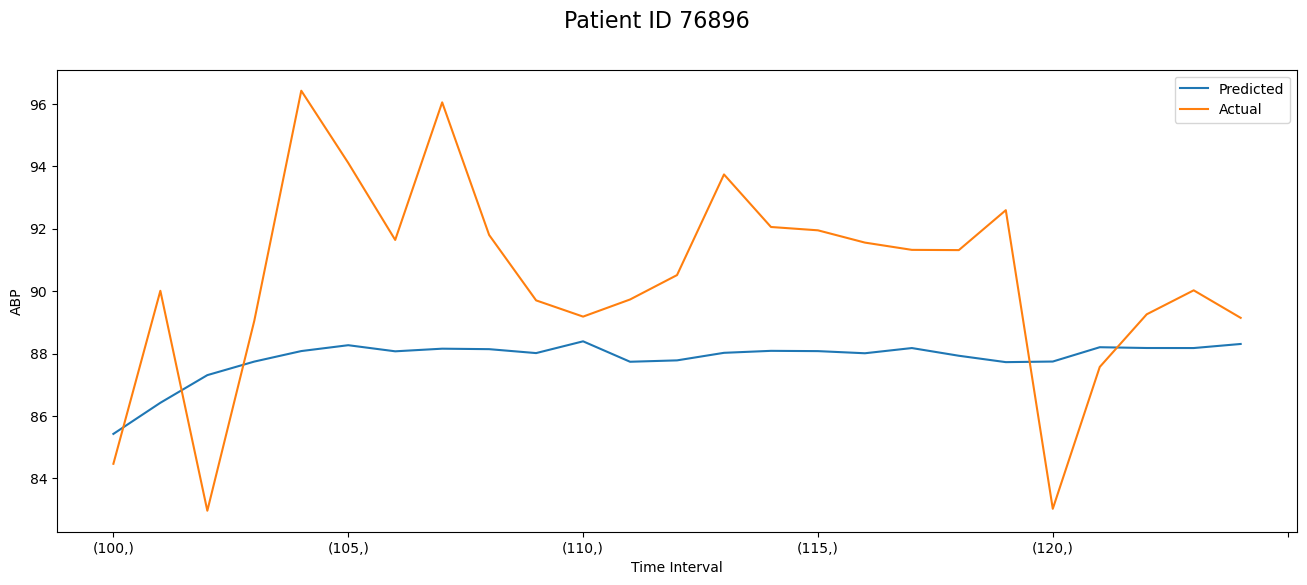

RMSE: 3.9497936828404954


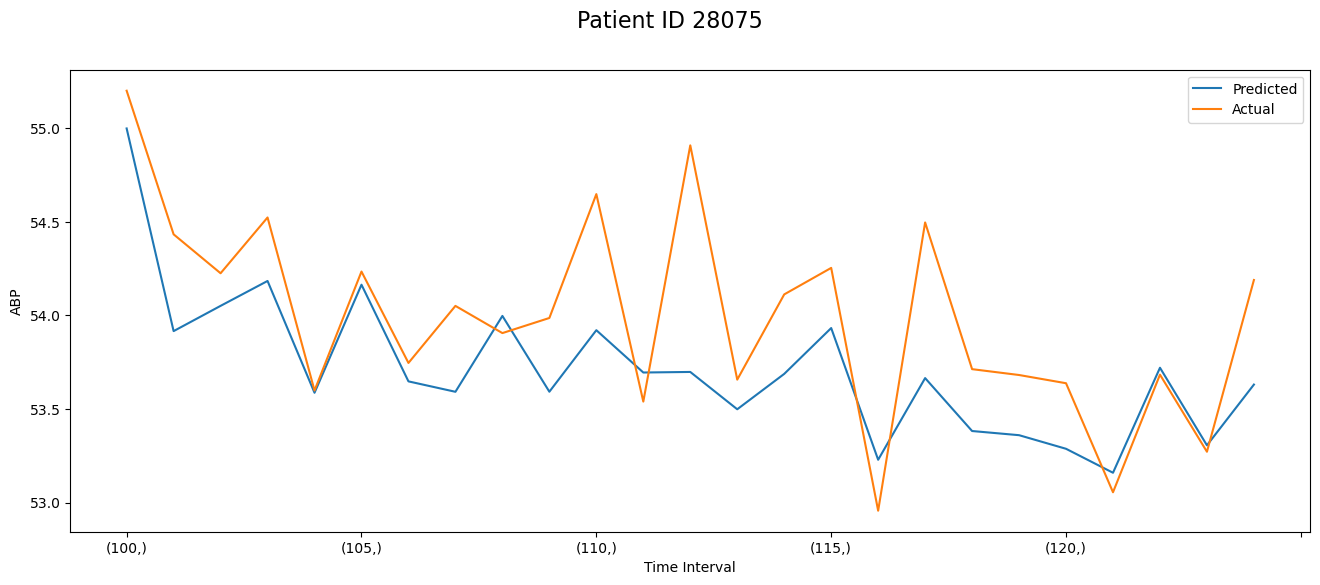

RMSE: 0.42892777362891227


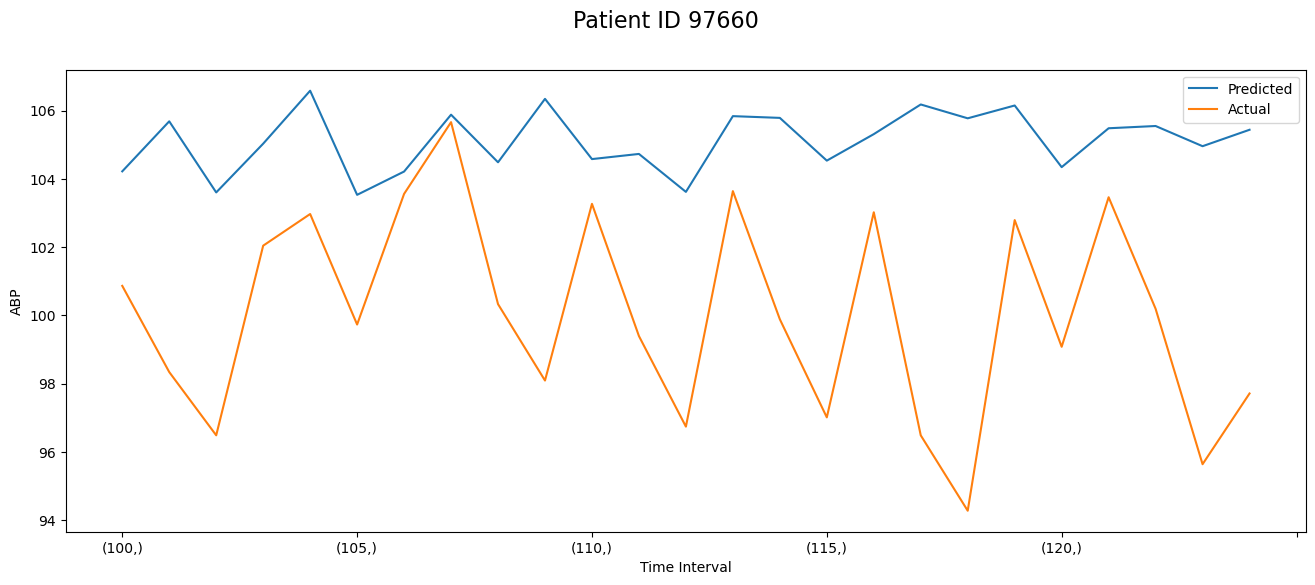

RMSE: 5.870739702157541


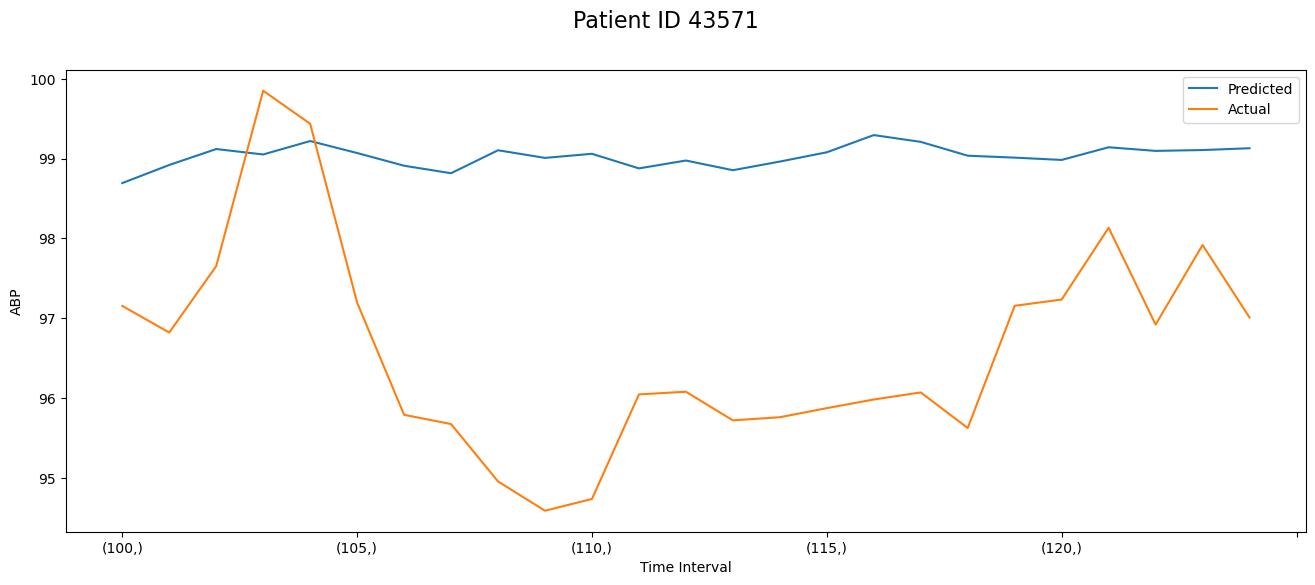

RMSE: 2.726238305900654


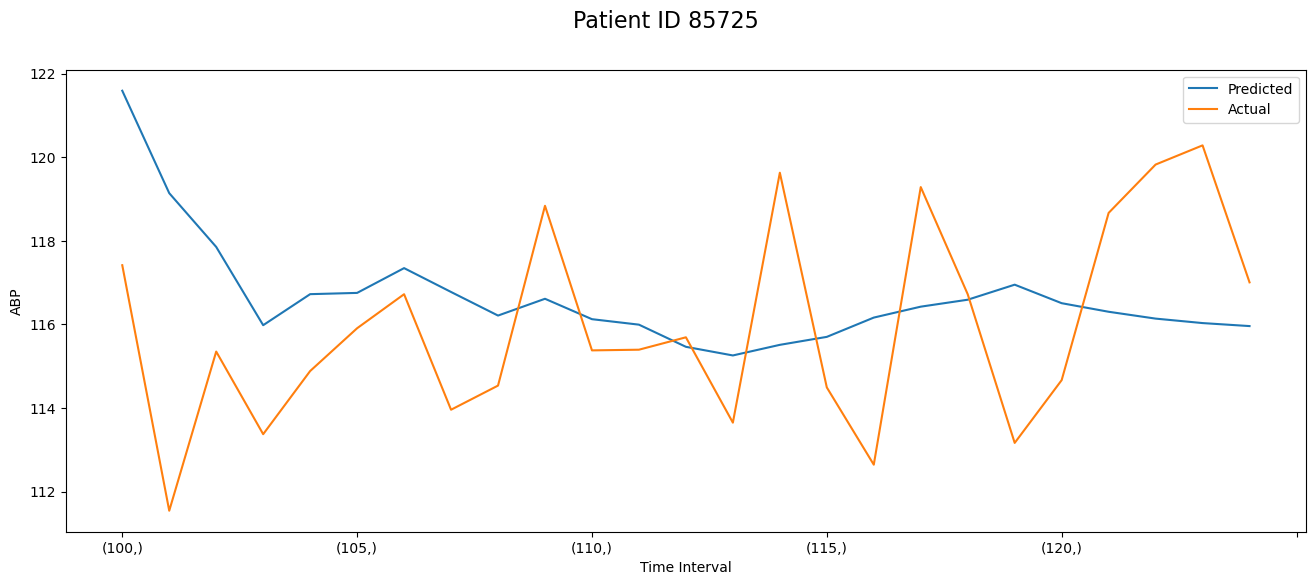

RMSE: 2.8784883730096524


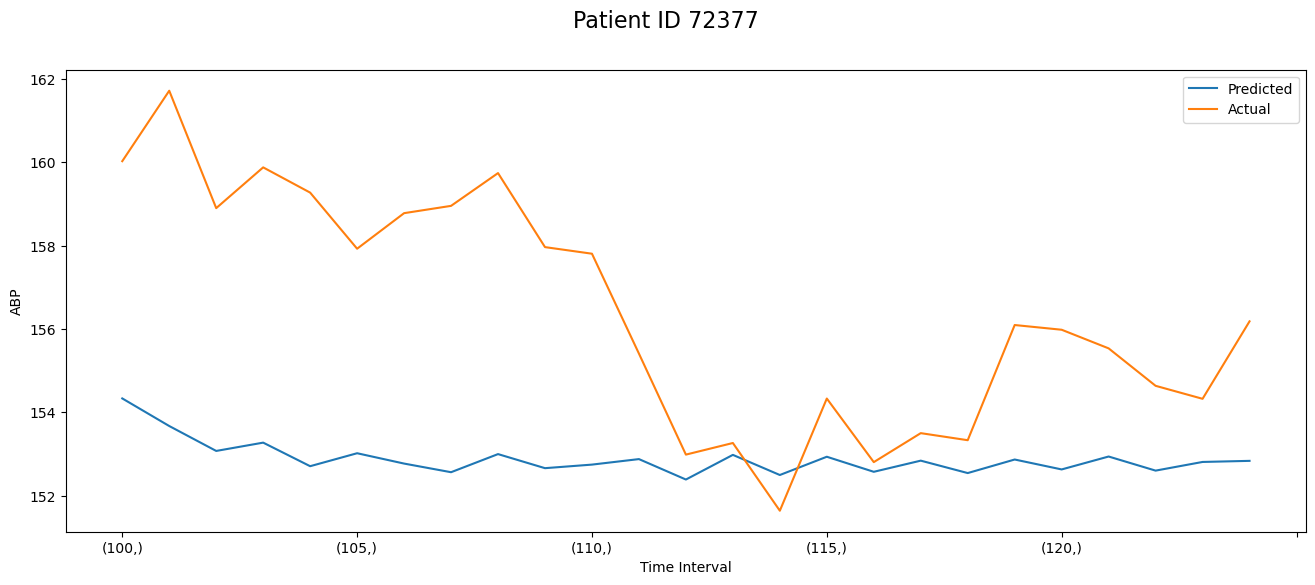

RMSE: 4.359421395902624


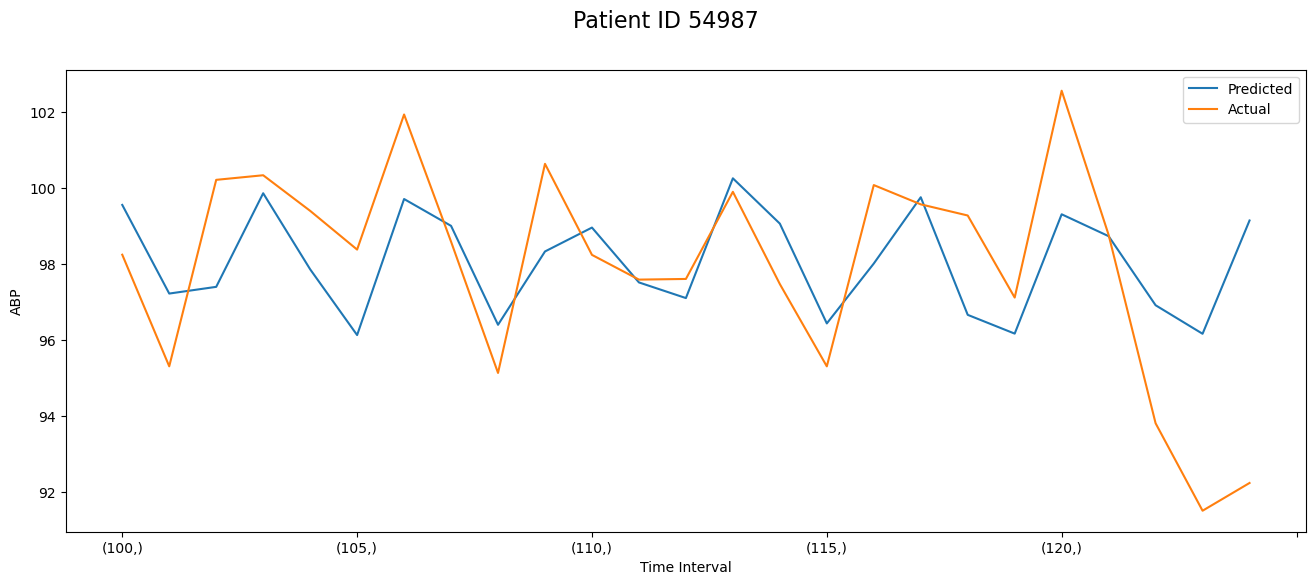

RMSE: 2.3614463841319178


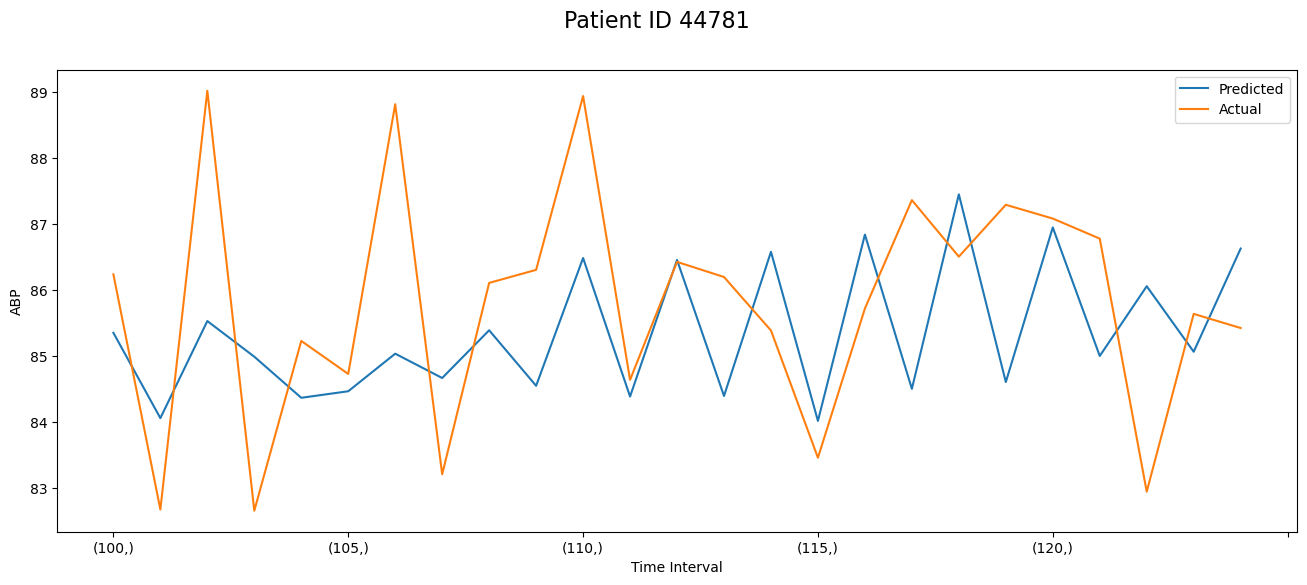

RMSE: 1.835787447272115


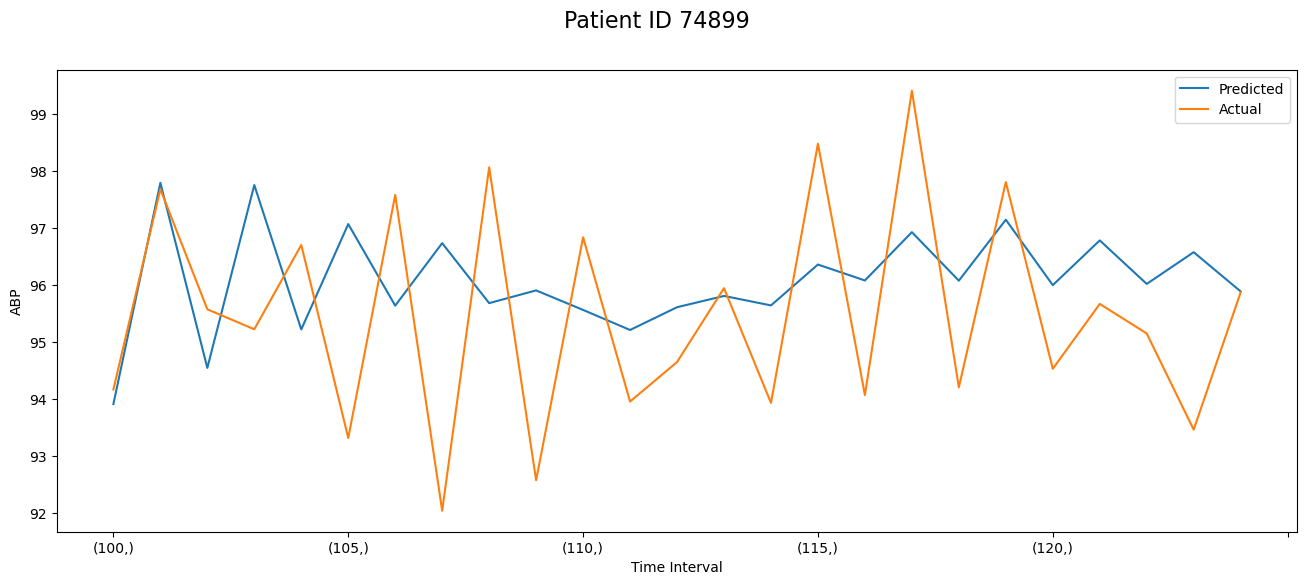

RMSE: 2.056829322119909


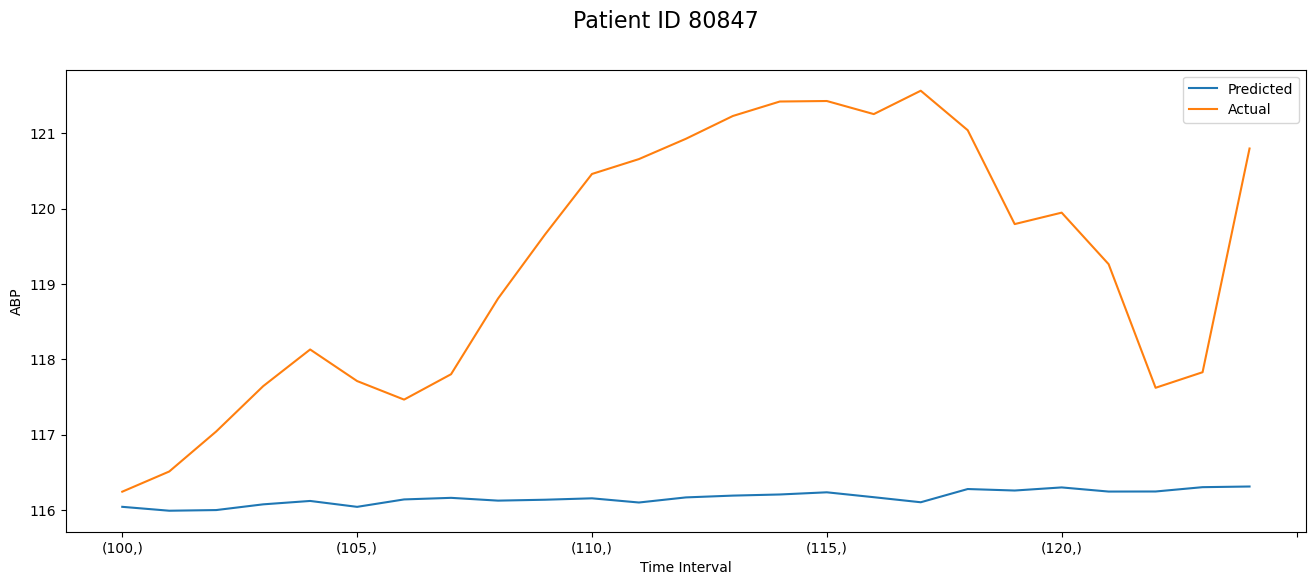

RMSE: 3.5430997697341615


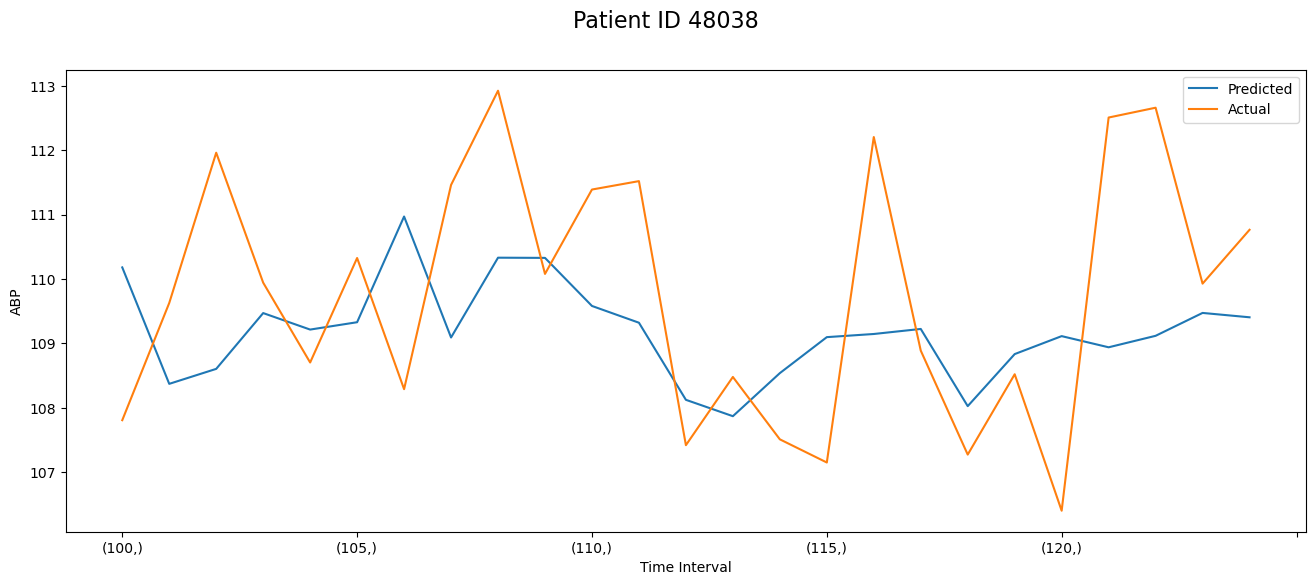

RMSE: 1.9825683817284325


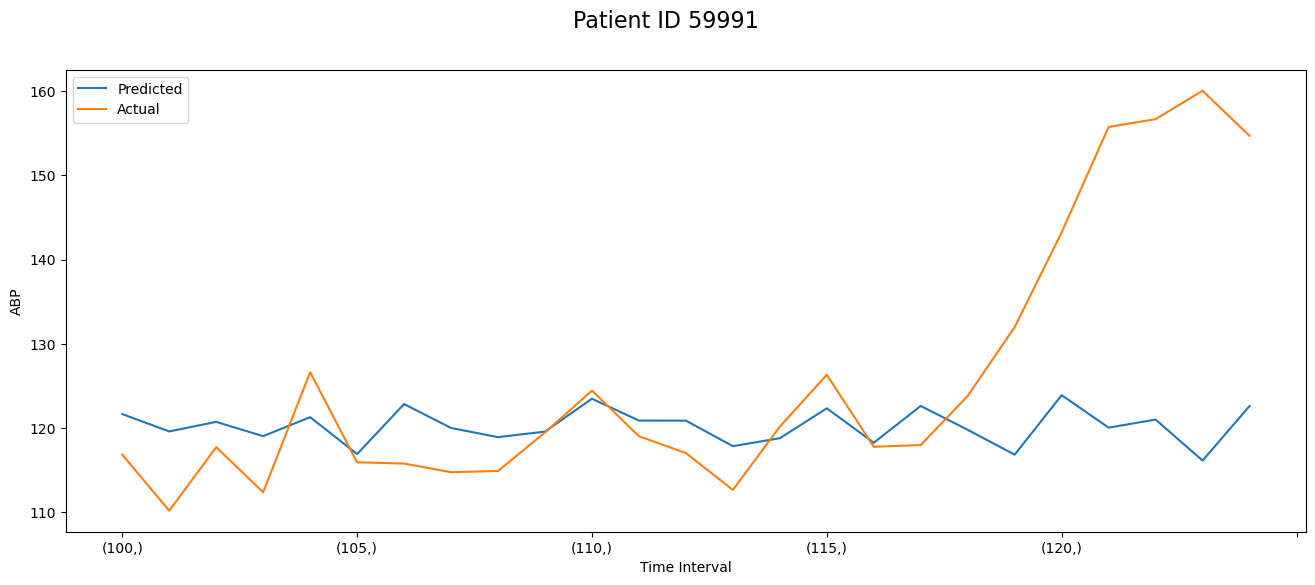

RMSE: 16.12297015332205


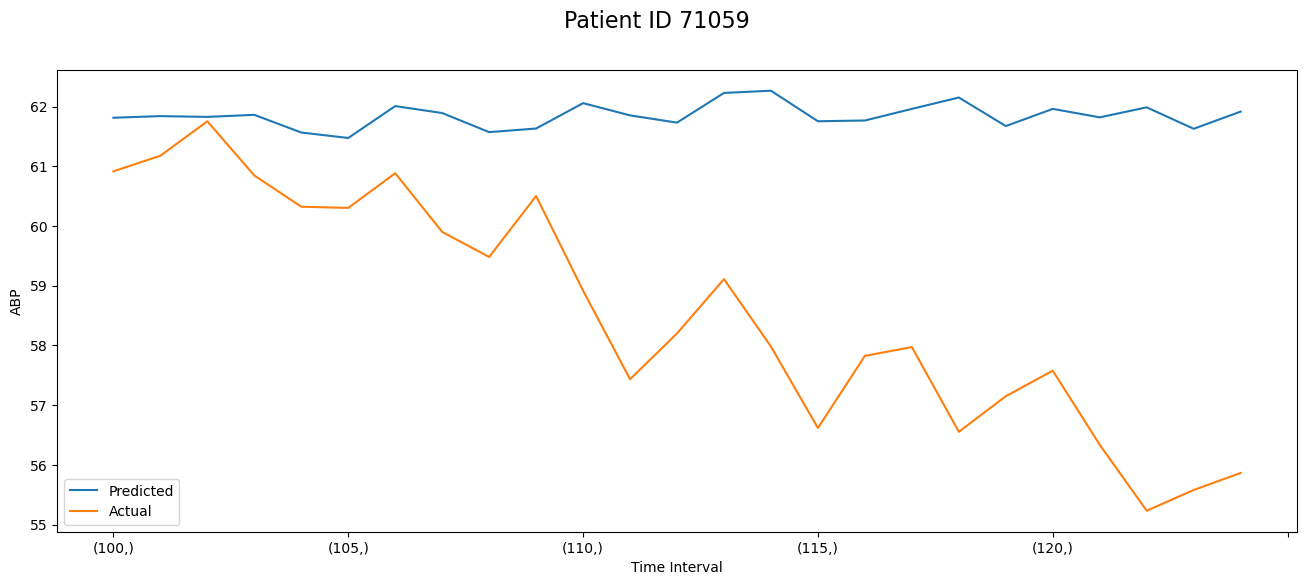

RMSE: 3.8145554898914082


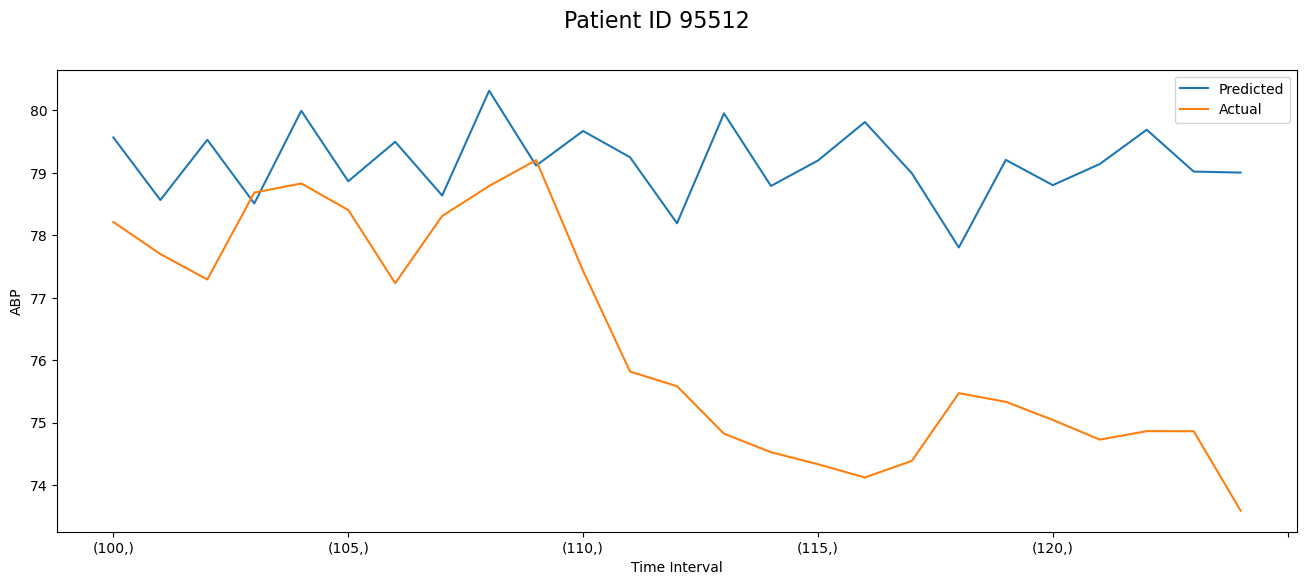

RMSE: 3.384044209924867


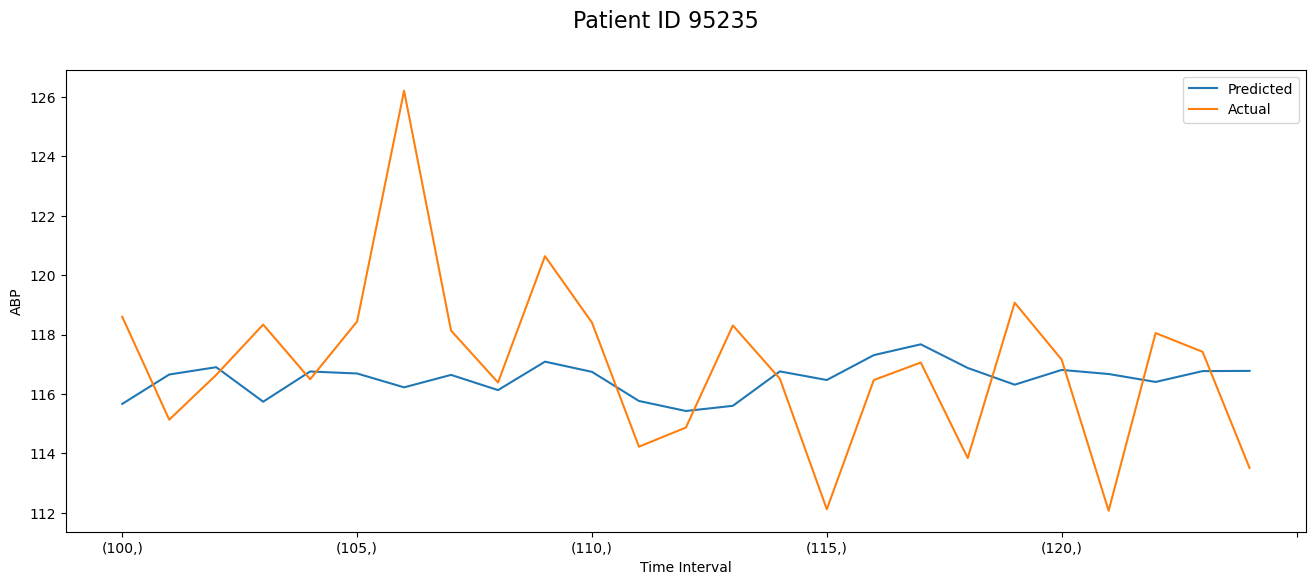

RMSE: 2.9690677630264677


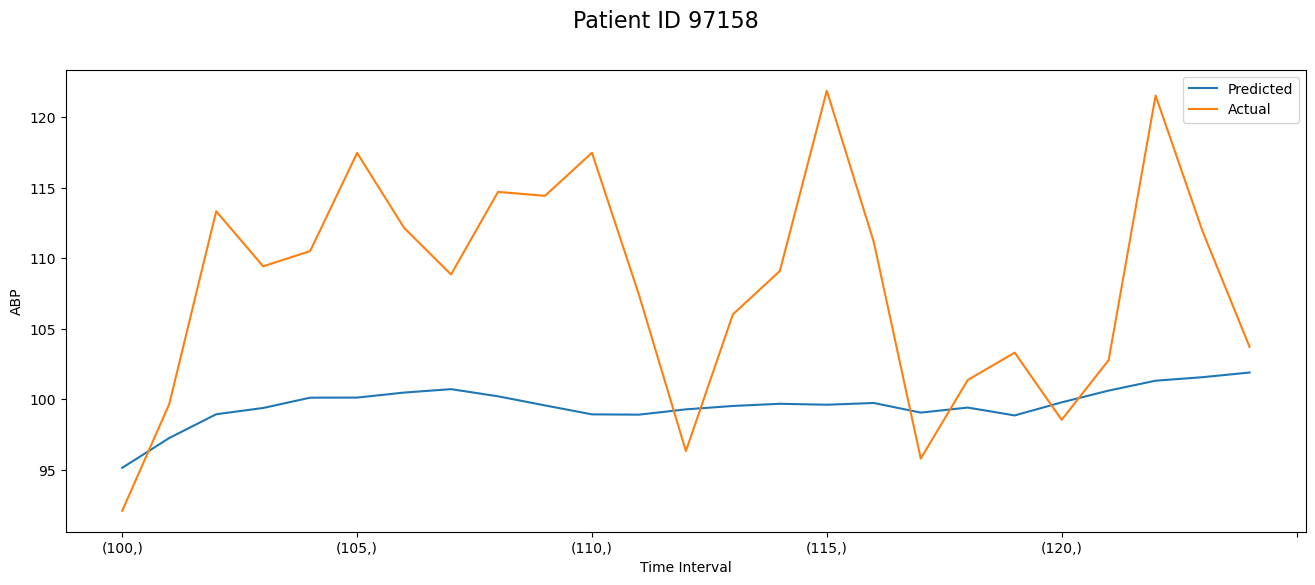

RMSE: 11.140027469895672


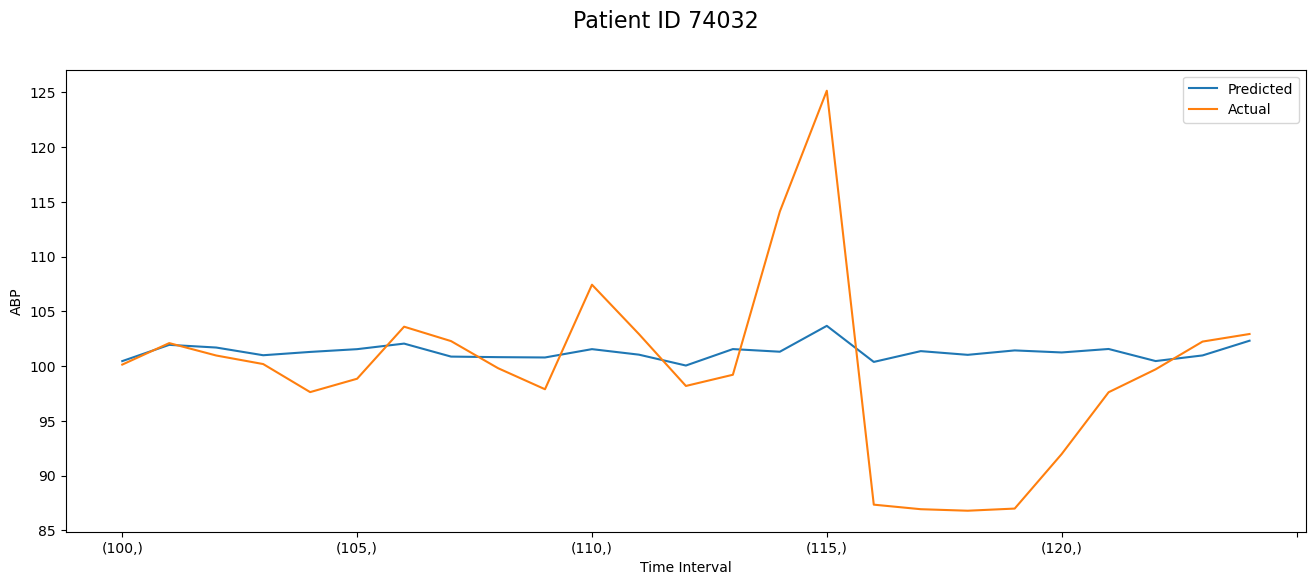

RMSE: 8.004501395333152


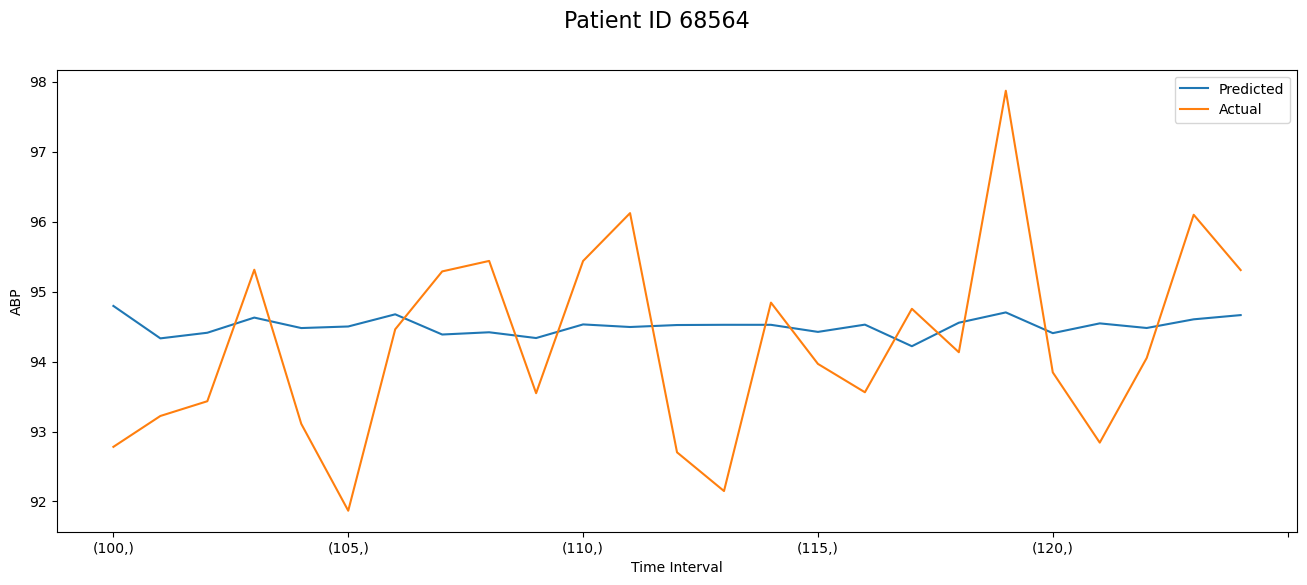

RMSE: 1.389128114440109


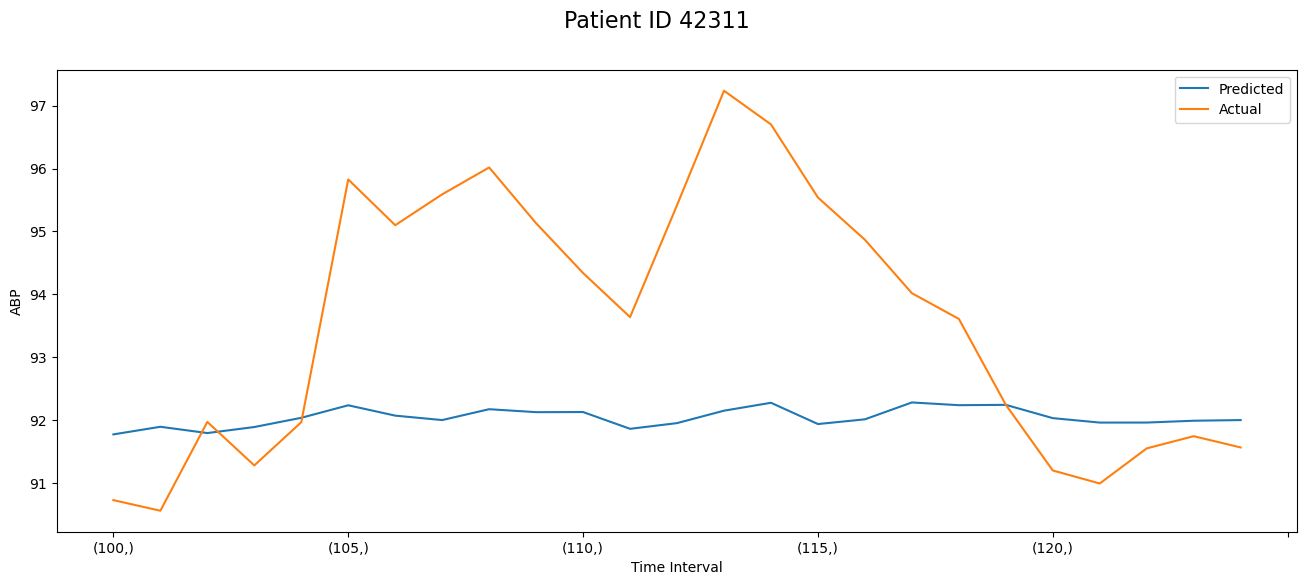

RMSE: 2.4936313817527616


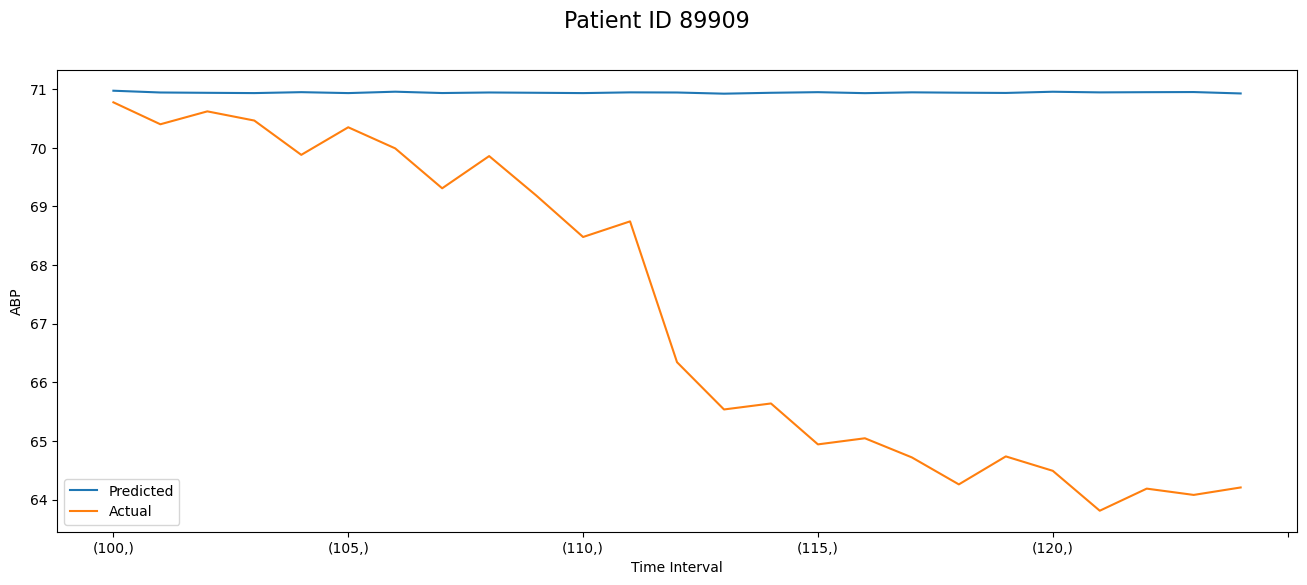

RMSE: 4.570701743830191


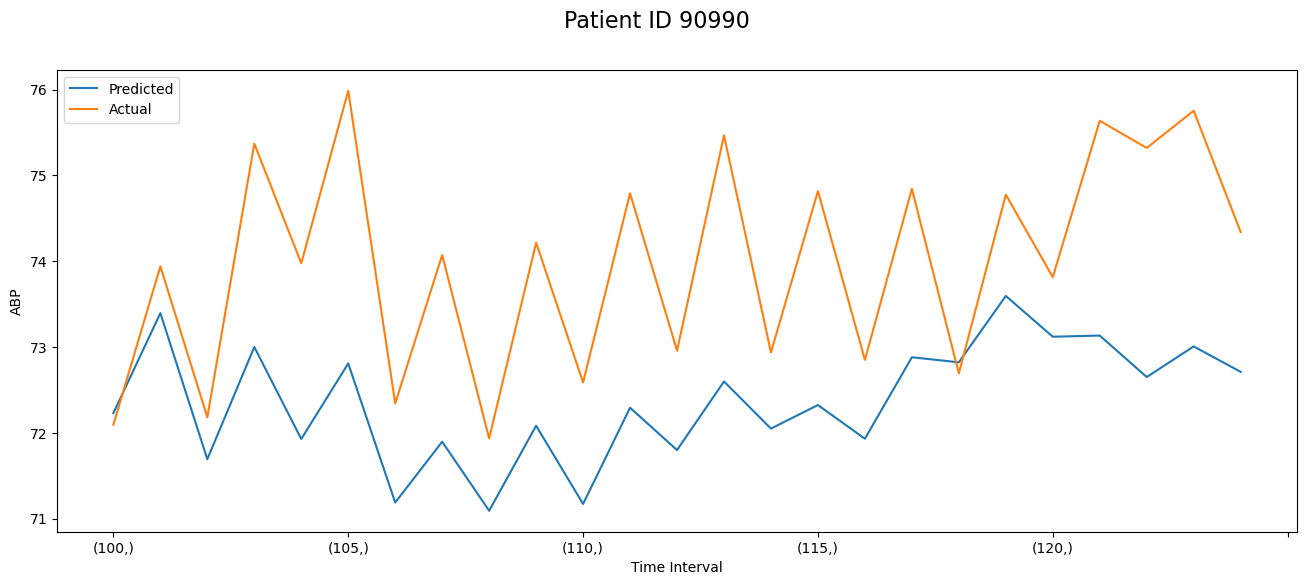

RMSE: 1.8636863382942477


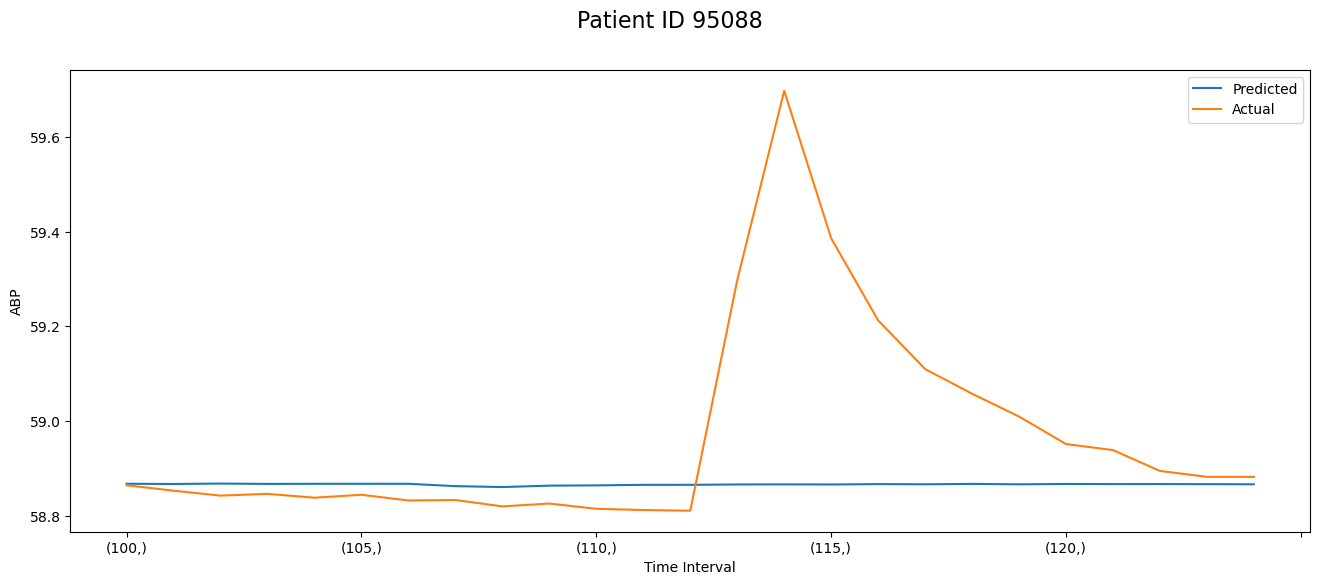

RMSE: 0.23782503719989034


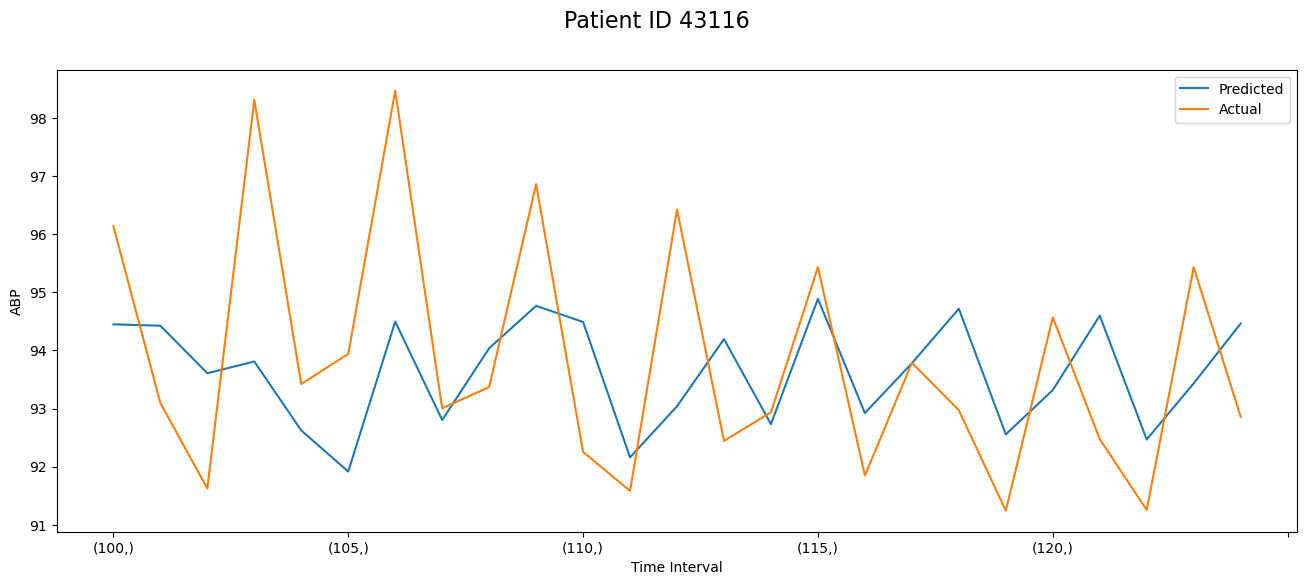

RMSE: 1.9436515355211037


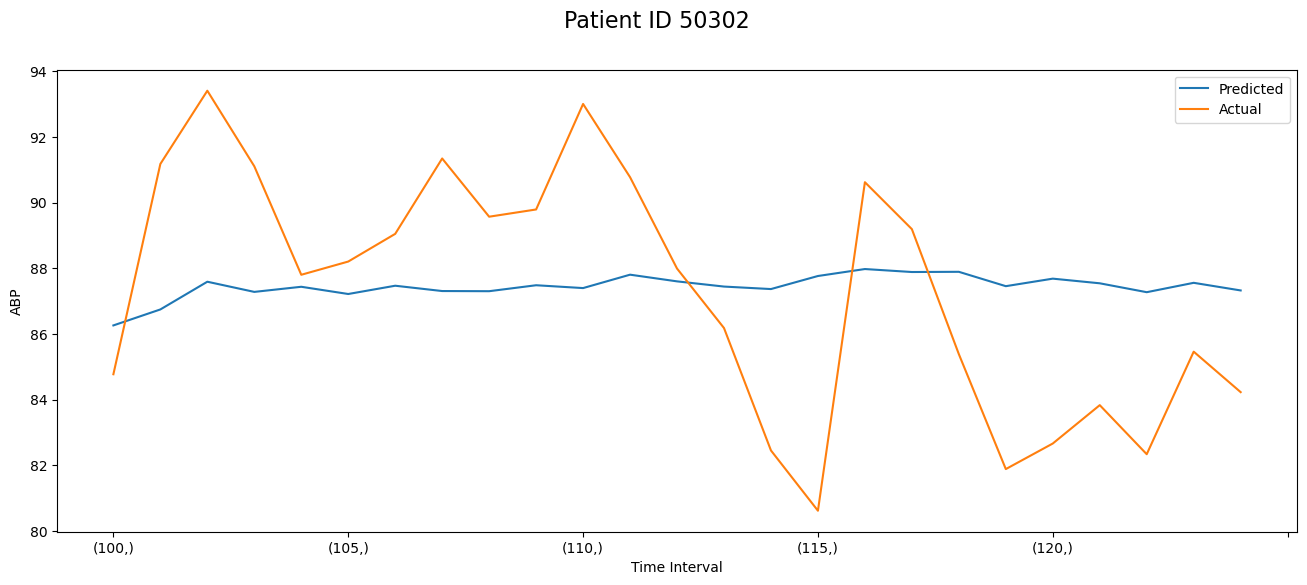

RMSE: 3.69604676032092


In [29]:
for patient_idx in new_patient_offsets:
    # Fit ARIMA model
    arima = ARIMA(ecg_subset.loc[patient_idx], order=(1, 1, 1), seasonal_order=(1, 0, 1, 20)) # Period best adjusts prediction
    model = arima.fit()

    # Predict ABP from ECG fit
    arima_clone = arima.clone(abp_subset.loc[patient_idx], ecg_subset.loc[patient_idx])
    model = arima_clone.fit()
    pred_start, pred_end = 100, 124
    pred_vals = model.predict(start=pred_start, end=124, dynamic=True)
    actual_vals = abp_subset.loc[patient_idx][pred_start:pred_end+1]
    plt.figure(figsize=(16, 6))
    pred_vals.plot(label='Predicted')
    actual_vals.plot(label='Actual')
    plt.suptitle(f'Patient ID {pat_data[patient_idx]}', fontsize=16)
    plt.xlabel('Time Interval')
    plt.ylabel('ABP')
    plt.legend()
    plt.show()

    print(f'RMSE: {np.sqrt(MSE(actual_vals, pred_vals))}')


# Conclusion
The ECG-ECG window correlation to ABP-ABP window showed a positive correlation with a Spearman coefficient of approximately 0.4. This confirms our hypothesis that ECG and ABP are correlated - as one changes the other changes too in a monotonic manner. Using ECG features extracted from tsfresh for a five minute window we were able to predict the mean ABP of that window with an RMSE of 21.4651 mmHg and MAE of 16.8276 mmHg. Given the general magnitude of the ABP waveform (normal waveform fluctuates between 80-120 mmHg, this is not terrible, but not also that great. Finally, for our forecasting ARIMA model trained on ECG data and predicting the last minute of ABP data (all downsampled), we had a large variation in prediction accuracy. We did a random prediction for each patient and had RMSEs varying from 0.42 mmHg to 11.4 mmHg. This could be that the ARIMA model does not generalize well to a single seasonal component and needs to be tailored for each input signal.